In [79]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_mamba import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [80]:
config = load_config("../config.yaml")
taskset = "PDM"

### Get dissimilarities

#### Computation dynamics

In [81]:
df = get_dataframe(taskset)
# df = df[(df["n_layers"]==2) & (df["d_model"]==8)]
groups_trained = ["master"]
other_groups = [group for group in df["group1"].unique() if group not in groups_trained]

groups_base = ["untrained", "master"]
groups_selected = ["pretrain_basic_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[
    # For rows where model1 is in group1
    ((df["group1"].isin(groups_trained)) & (df["accuracy_1"] > 0.99))
    |
    # For rows where model1 is not in group1 (accuracy_1 can be anything)
    (~df["group1"].isin(groups_trained))
    |
    # For rows where model2 is in group2
    ((df["group2"].isin(groups_trained)) & (df["accuracy_2"] > 0.99))
    |
    # For rows where model2 is not in group2 (accuracy_2 can be anything)
    (~df["group2"].isin(groups_trained))
]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]

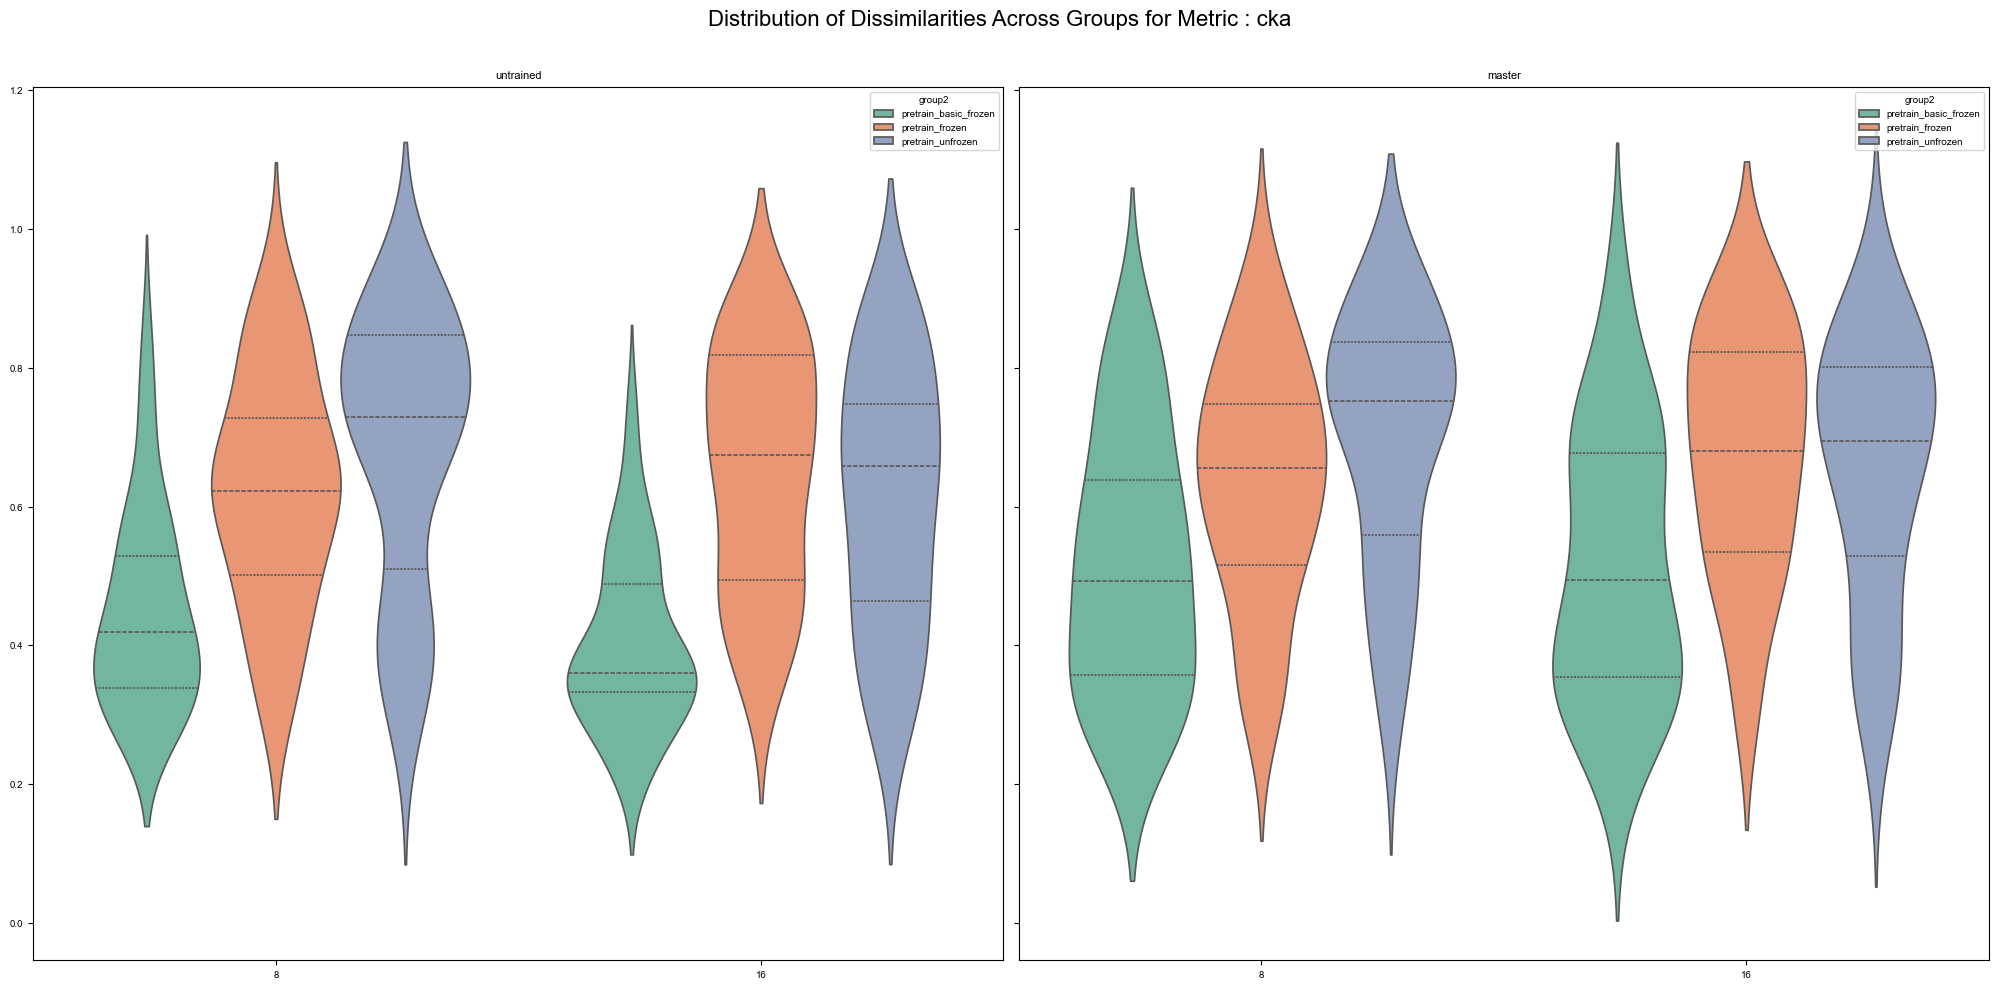

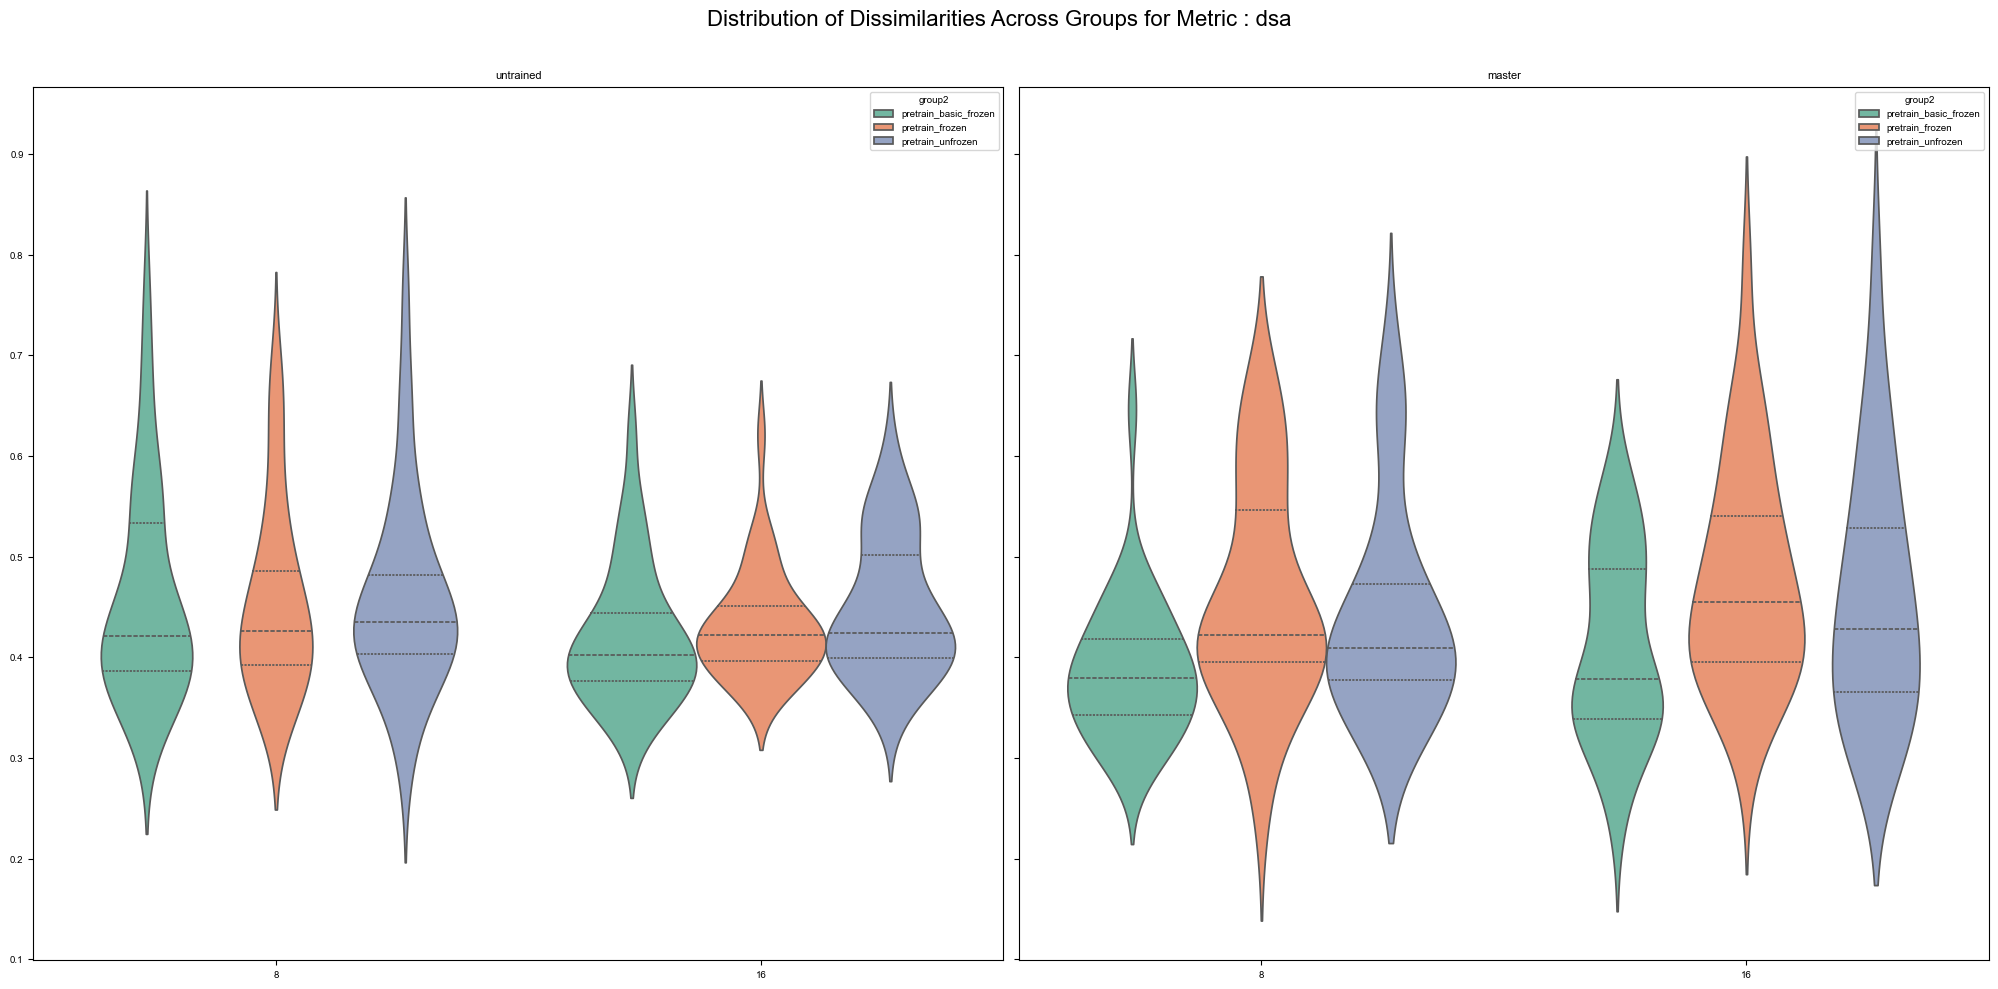

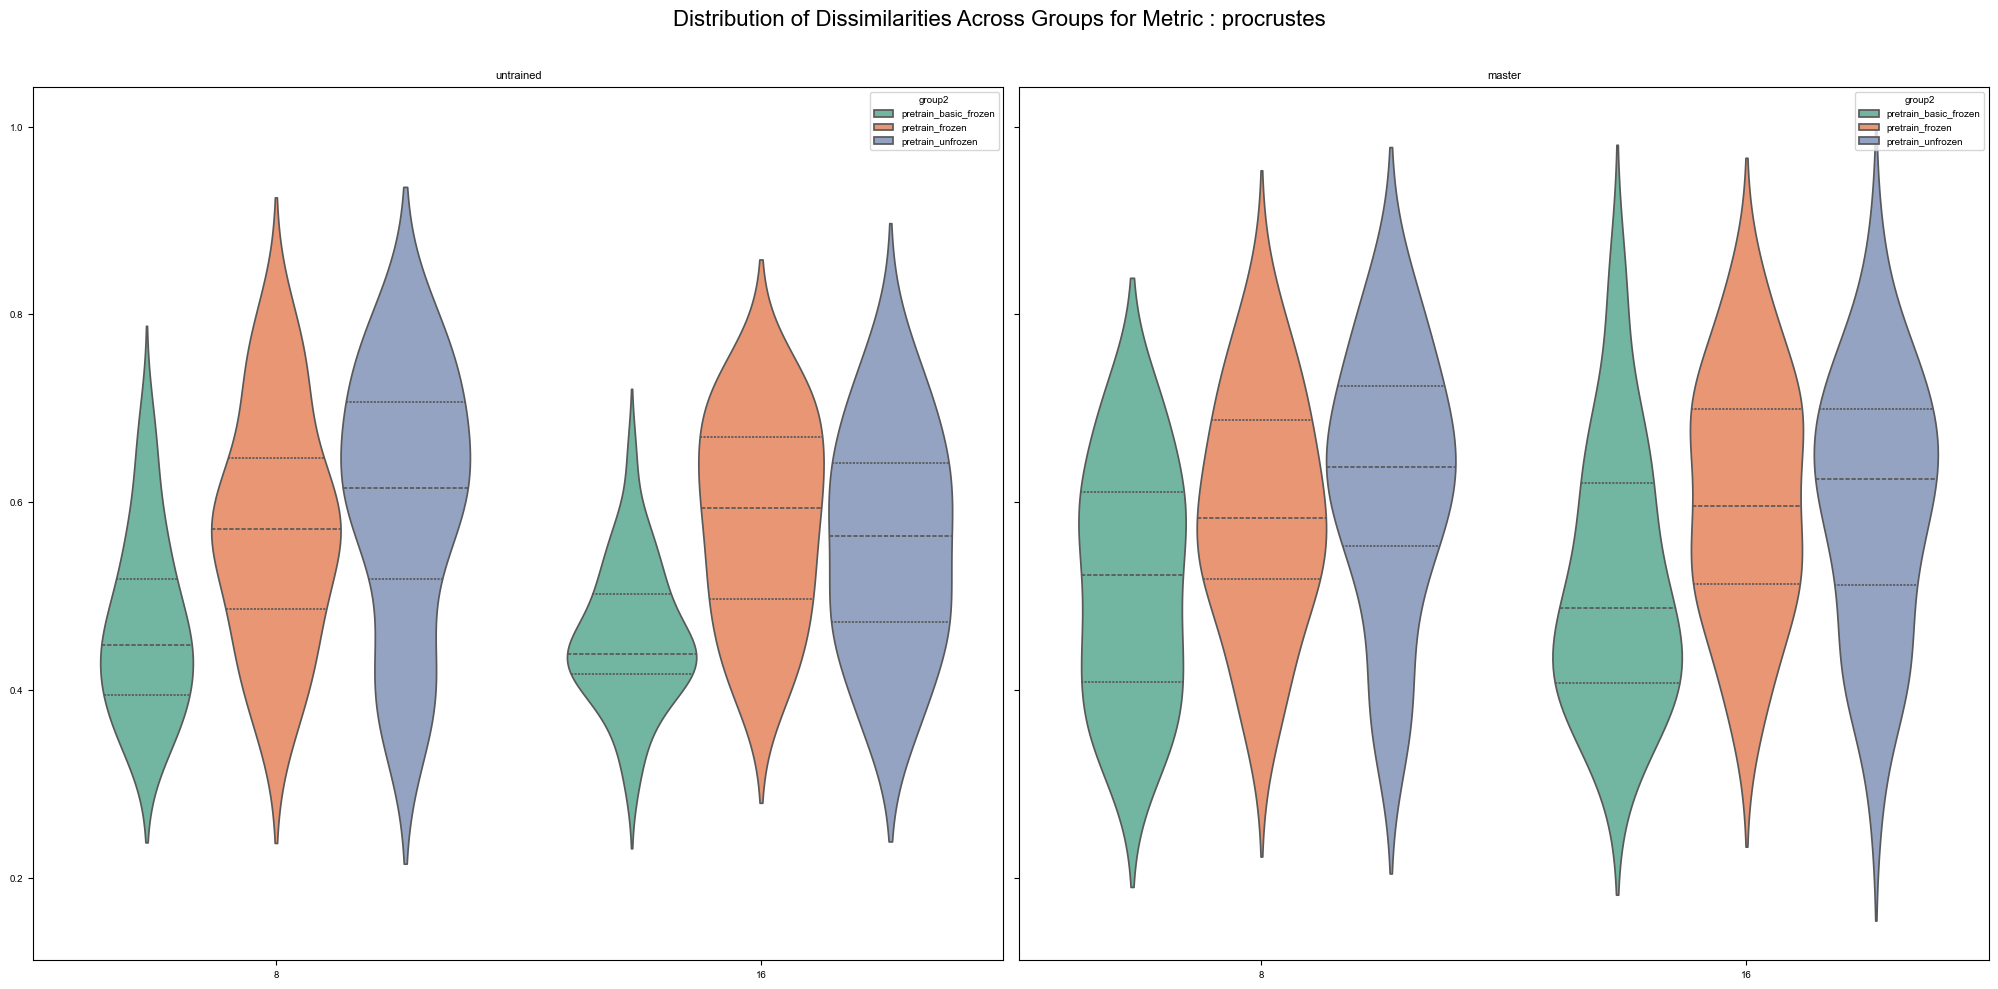

In [82]:

for measure in ["cka", "dsa","procrustes"]:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) &
                (df_selected["measure"] == measure)
            ],
            x="d_model",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [83]:
df

,d_model,n_layers,learning_rate,batch_size,group1,group2,measure,dissimilarity,accuracy_1,accuracy_2
0,8,2,0.010,16,untrained,untrained,cka,0.000000,-1.0,-1.000000
1,8,2,0.010,16,untrained,master_frozen,cka,0.273957,-1.0,0.539886
2,8,2,0.010,16,untrained,master,cka,0.677729,-1.0,1.000000
3,8,2,0.010,16,untrained,pretrain_basic_frozen,cka,0.618510,-1.0,0.982076
4,8,2,0.010,16,untrained,pretrain_anti_frozen,cka,0.695532,-1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
19195,8,1,0.001,32,pretrain_unfrozen,pretrain_delay_frozen,procrustes,0.739423,1.0,1.000000
19196,8,1,0.001,32,pretrain_unfrozen,pretrain_basic_anti_frozen,procrustes,0.565706,1.0,1.000000
19197,8,1,0.001,32,pretrain_unfrozen,pretrain_basic_delay_frozen,procrustes,0.607667,1.0,0.946842
19198,8,1,0.001,32,pretrain_unfrozen,pretrain_frozen,procrustes,0.558218,1.0,1.000000


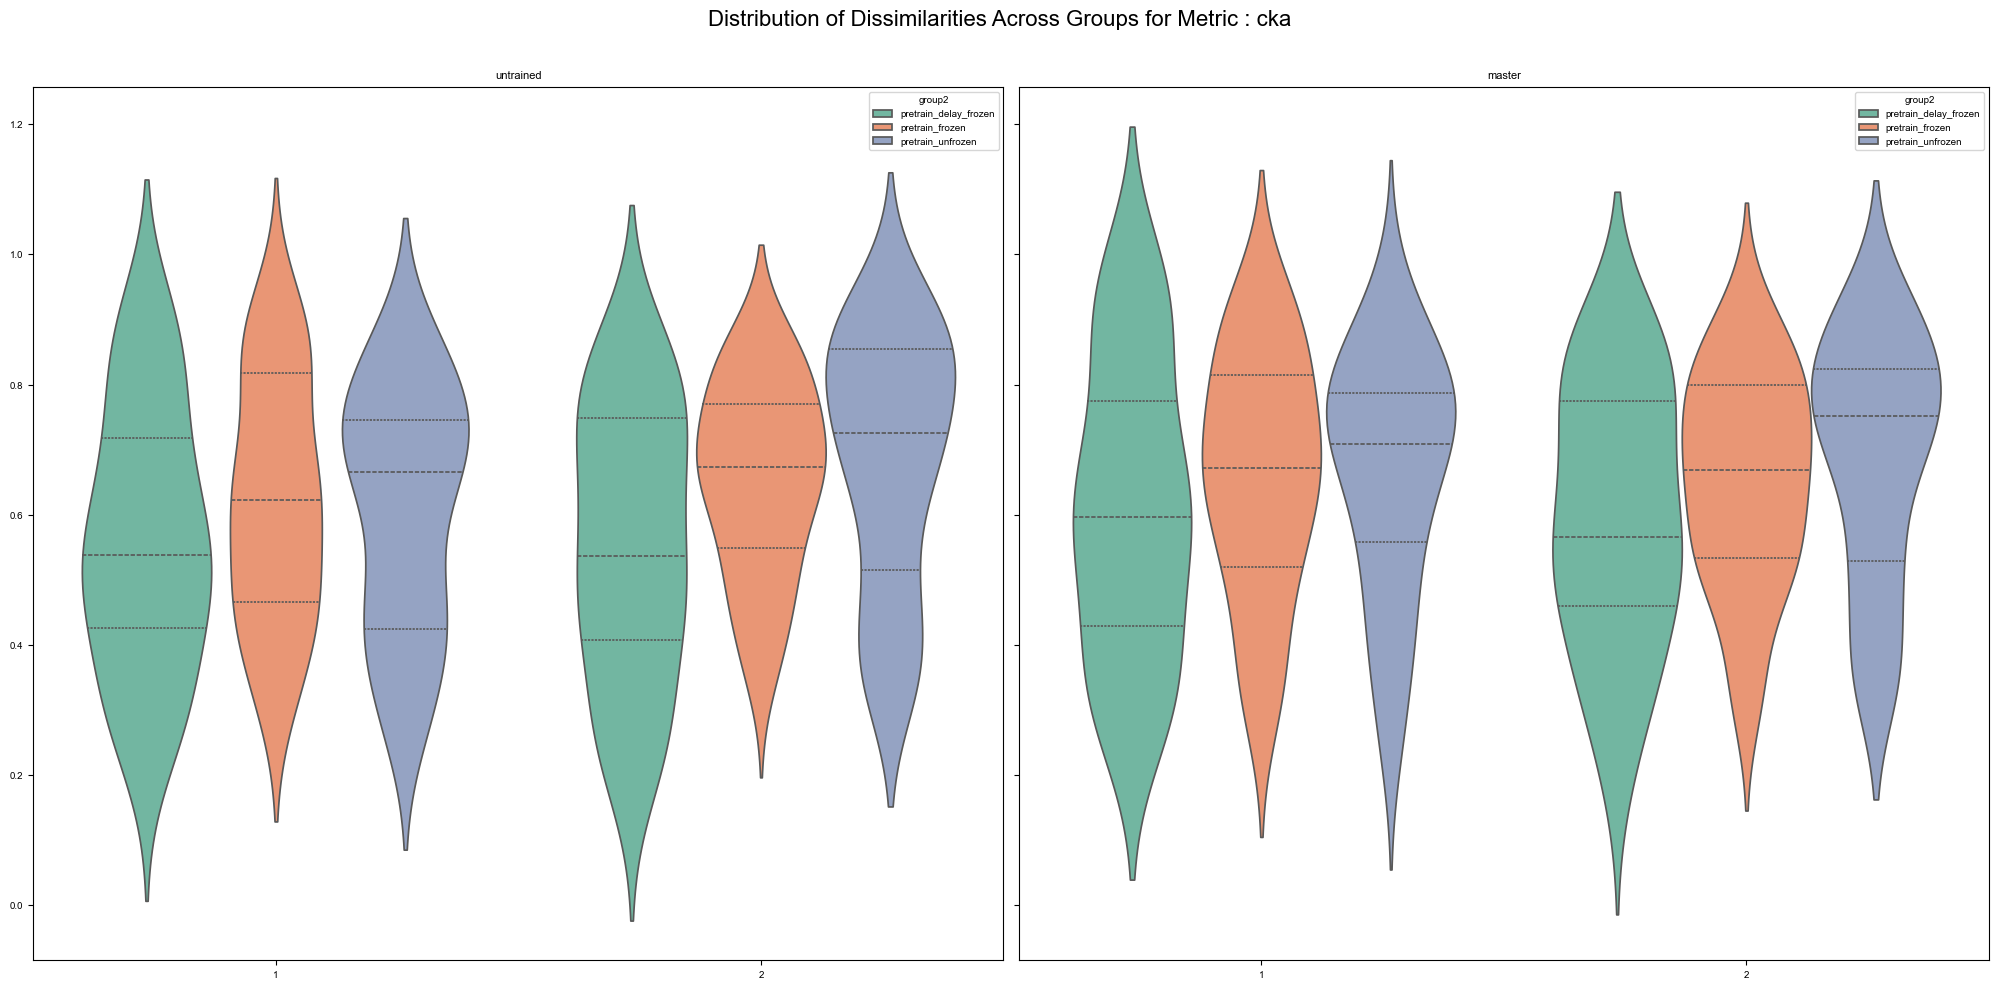

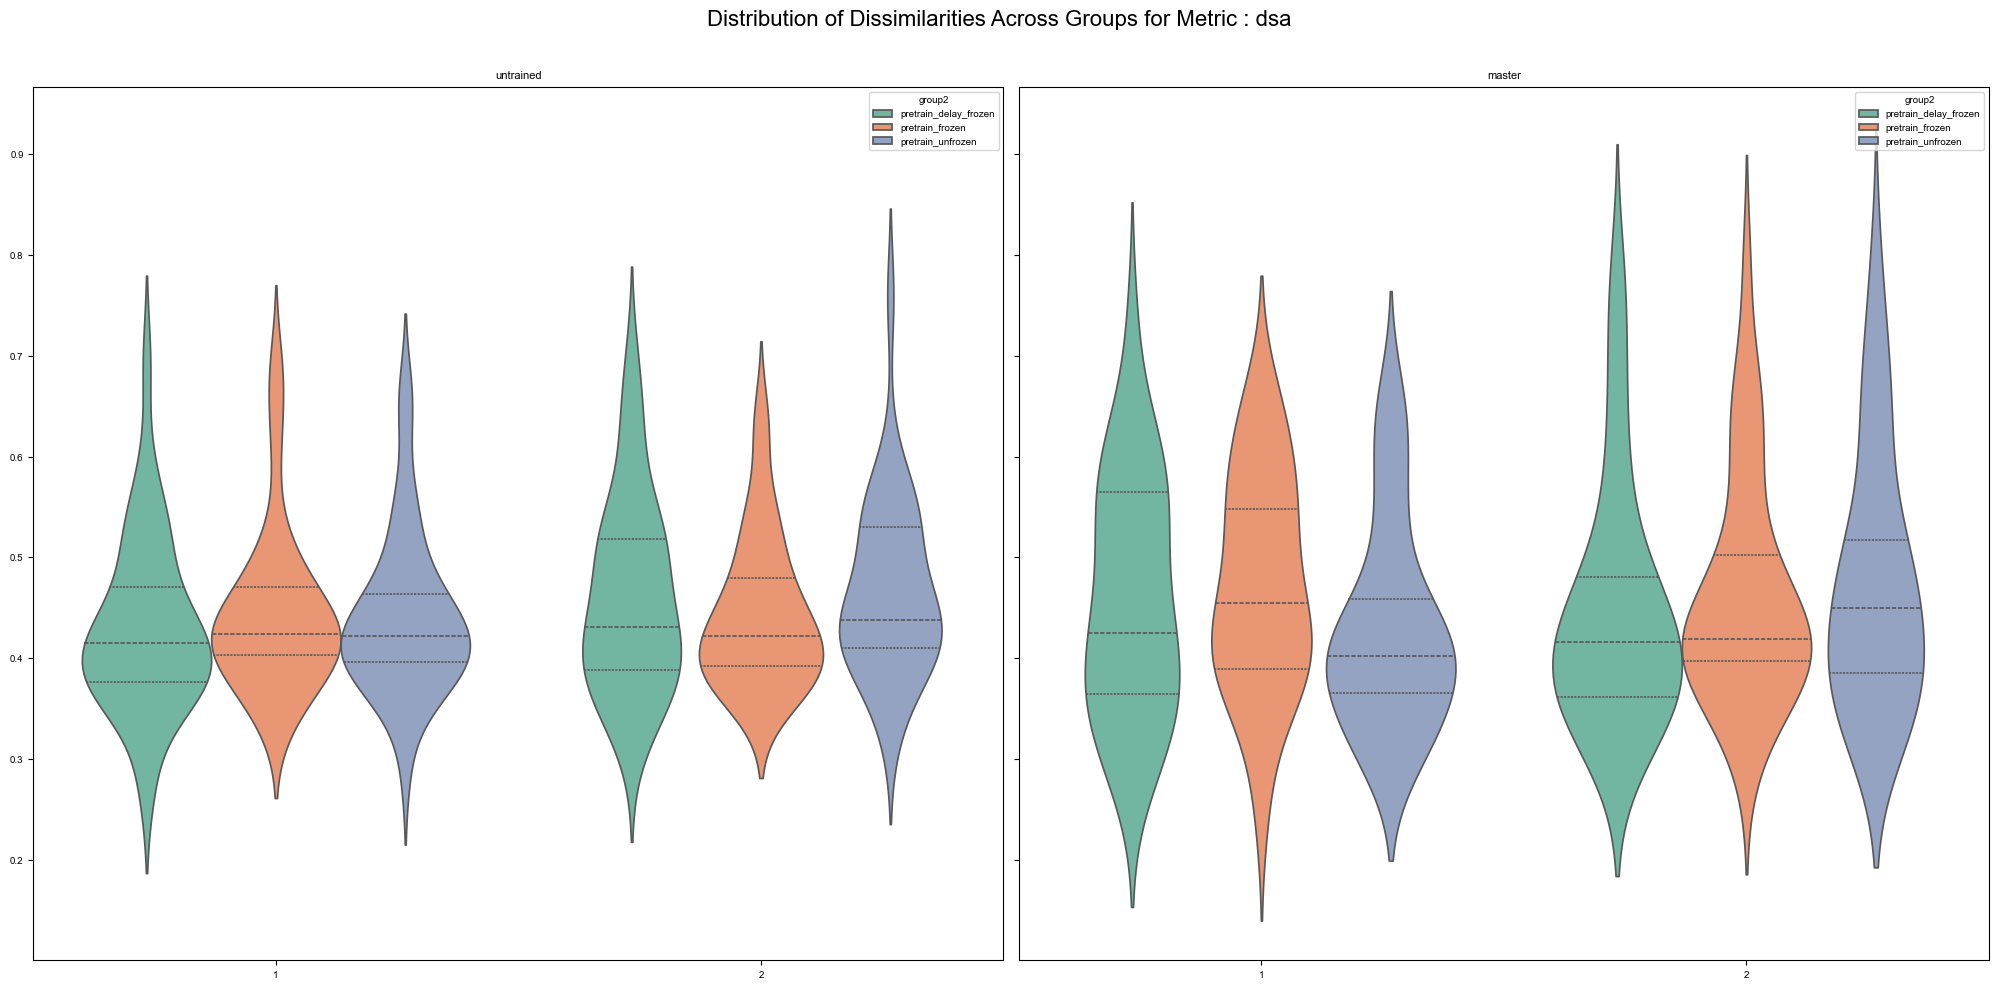

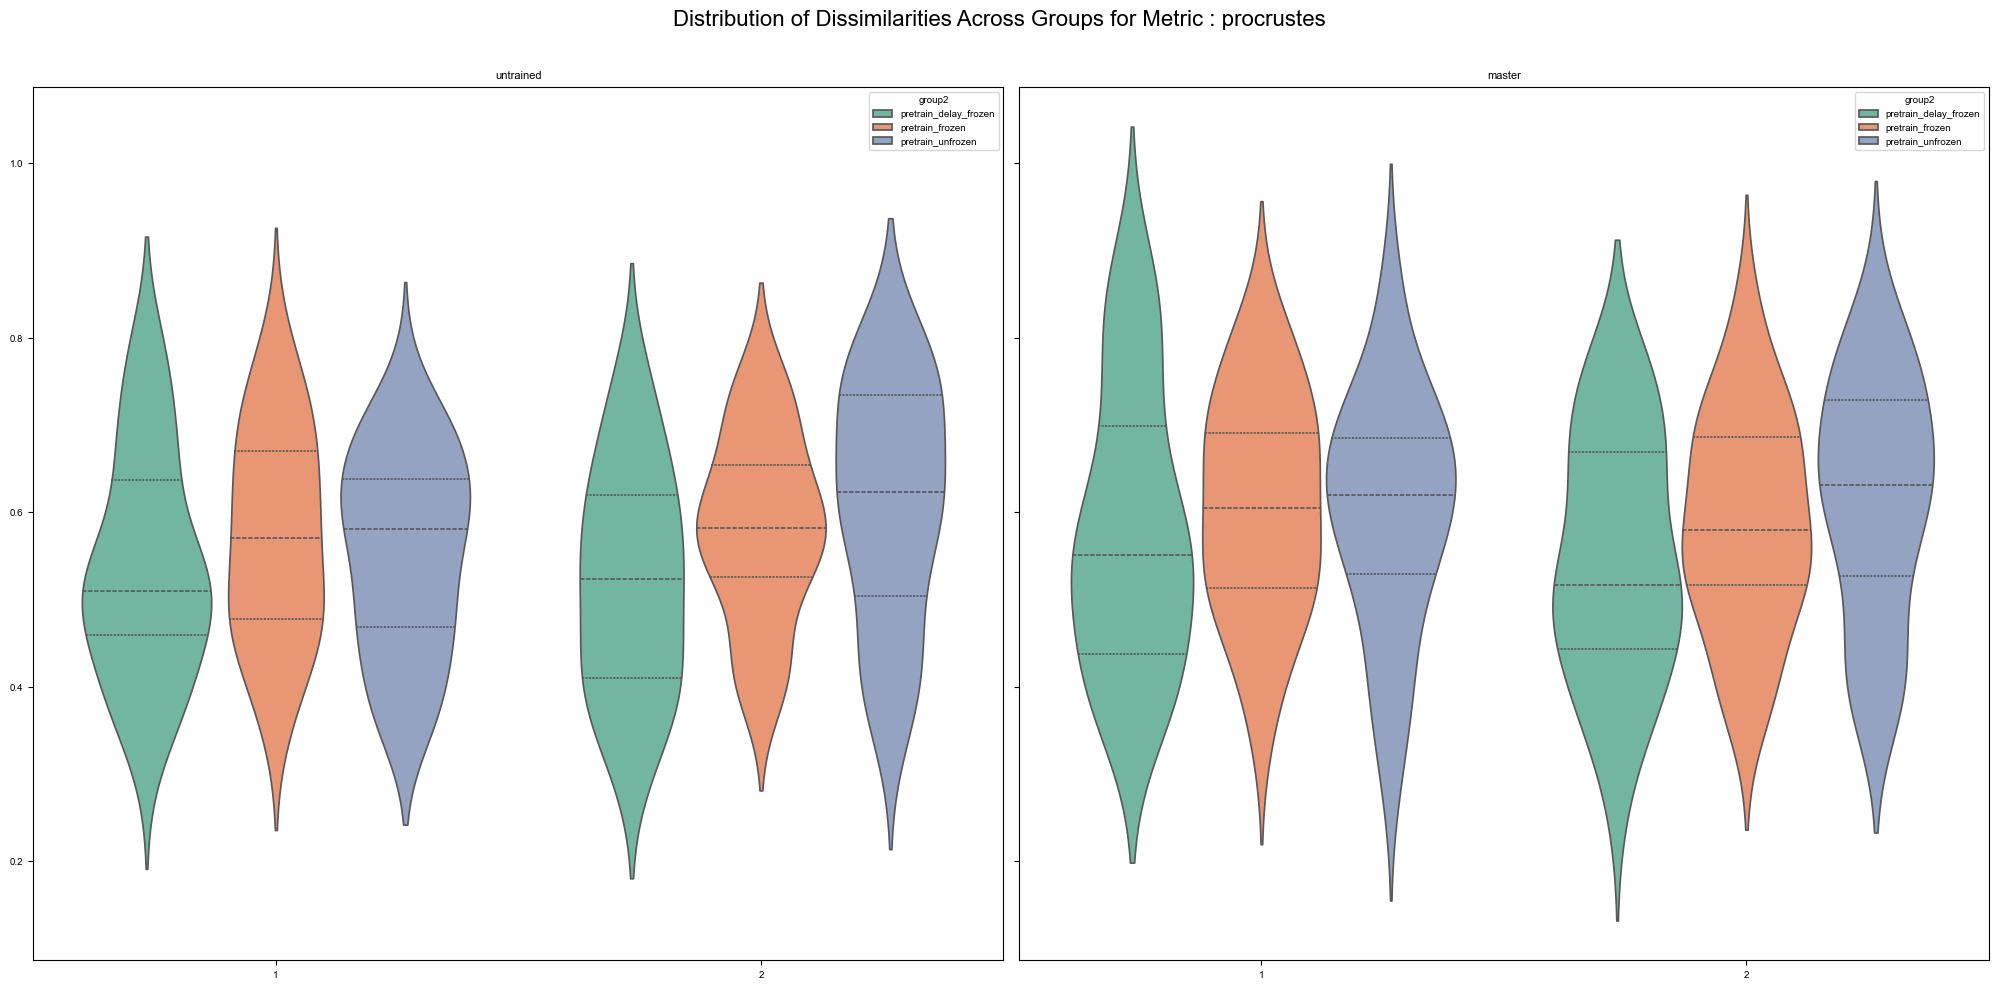

In [84]:
from math import log

groups_base = ["untrained", "master"]
groups_selected = ["pretrain_delay_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]
for measure in ["cka", "dsa", "procrustes"]:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ],
            x="n_layers",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [85]:
# df = df[(df["n_layers"]==2) & (df["d_model"]==8)]
groups_trained = ["master", "pretrain_frozen", "pretrain_unfrozen"]
other_groups = [group for group in df["group1"].unique() if group not in groups_trained]

In [86]:
df_selected = df[
    # For rows where model1 is in group1
    ((df["group1"].isin(groups_trained)) & (df["accuracy_1"] > 0.95))
    |
    # For rows where model1 is not in group1 (accuracy_1 can be anything)
    (~df["group1"].isin(groups_trained))
    |
    # For rows where model2 is in group2
    ((df["group2"].isin(groups_trained)) & (df["accuracy_2"] > 0.95))
    |
    # For rows where model2 is not in group2 (accuracy_2 can be anything)
    (~df["group2"].isin(groups_trained))
]

In [87]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df.groupby(["group1", "group2", "measure"])["dissimilarity"].median().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

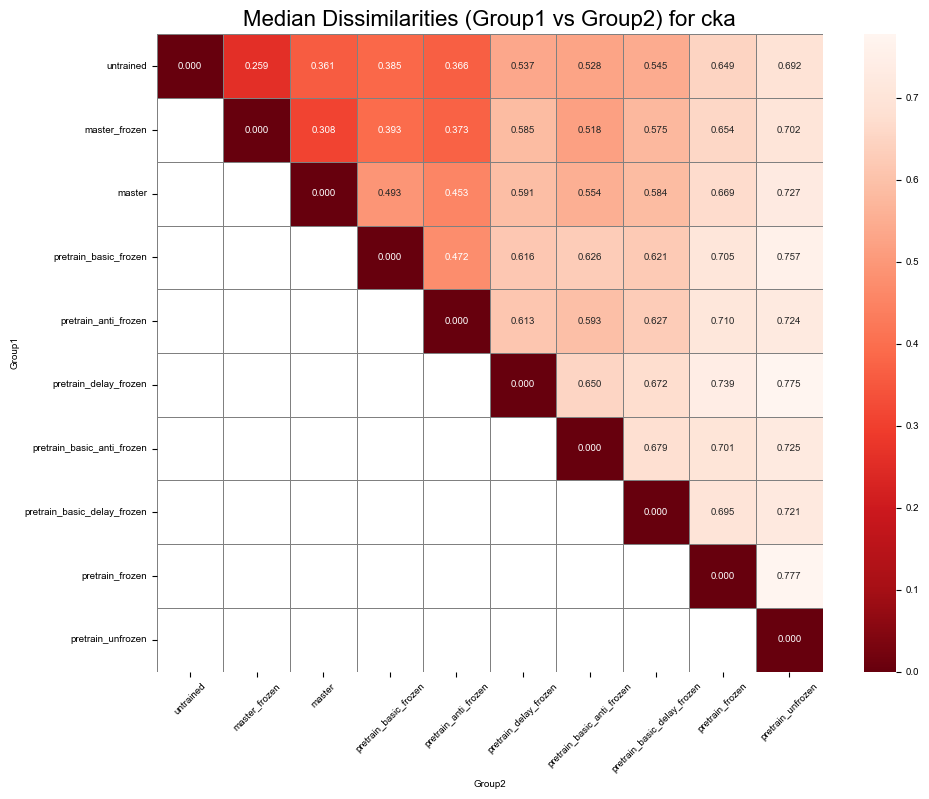

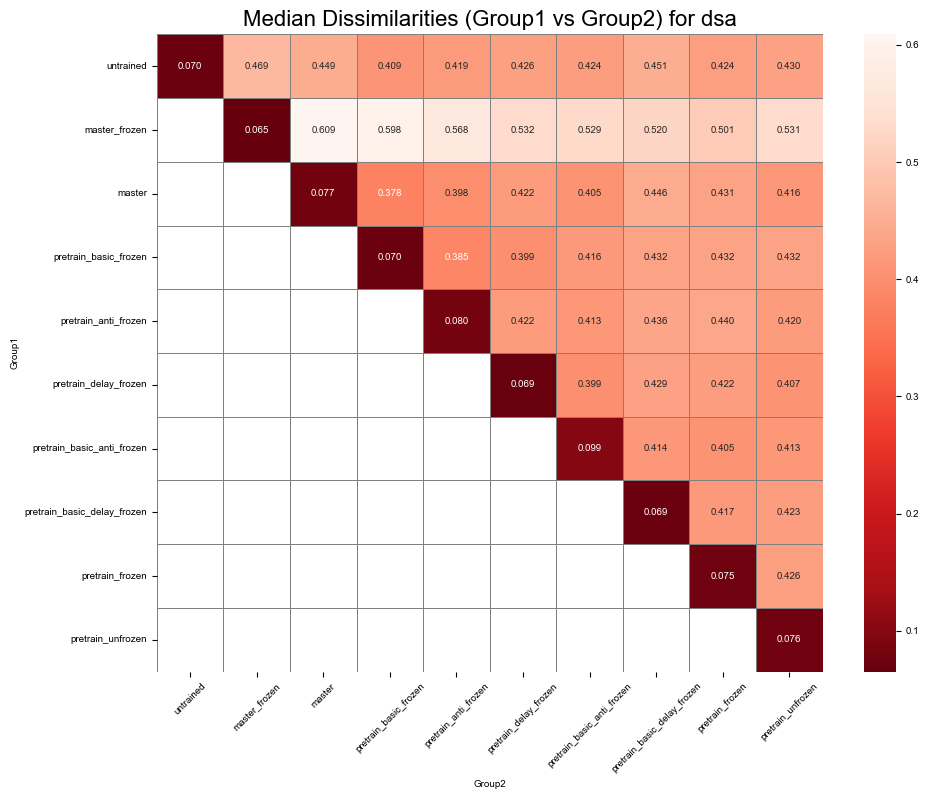

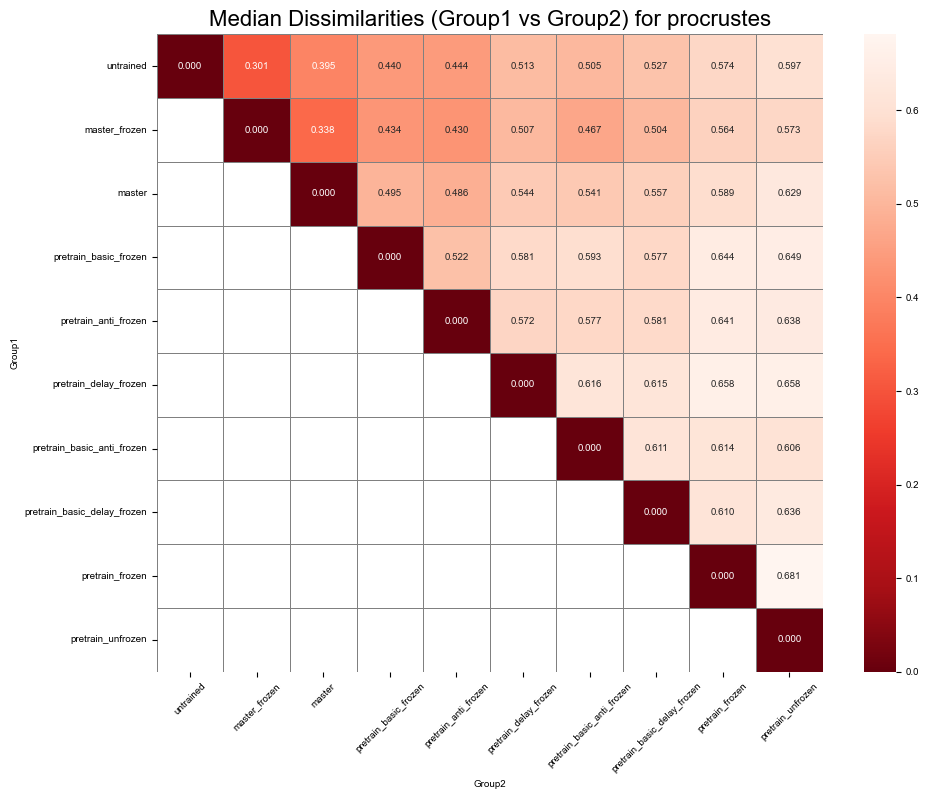

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5646/1102094897.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_vs_all["group2"] = master_vs_all["group2"].apply(map_group)


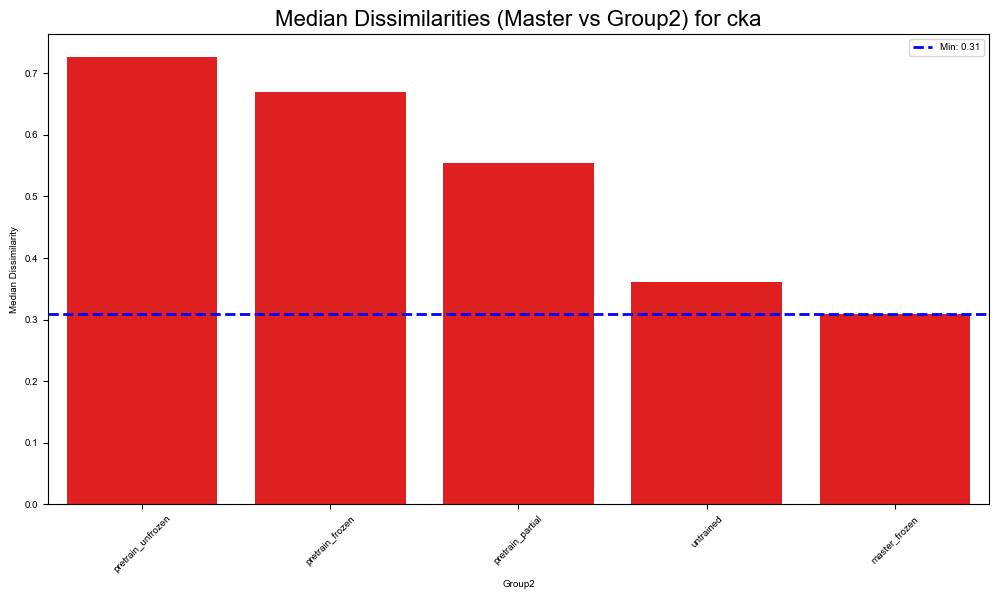

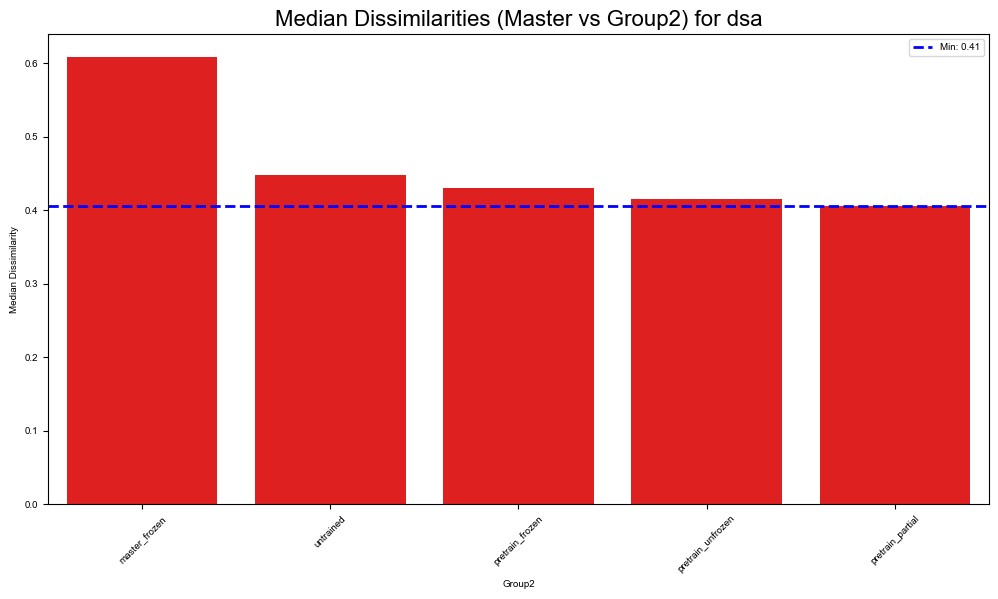

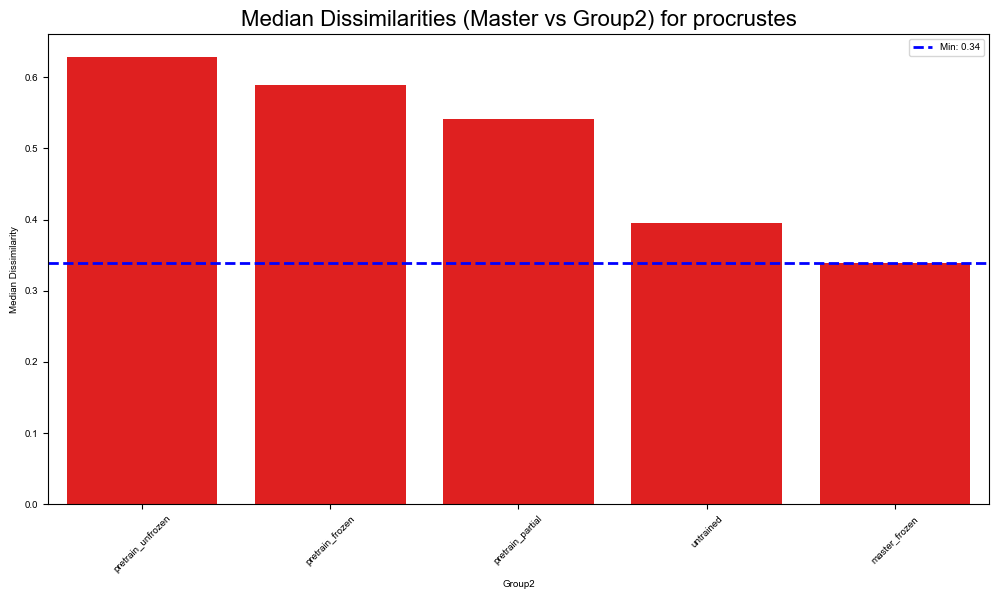

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter to get only the rows where group1 is 'master' and group2 is not 'master'
master_vs_all = median_dissimilarities[
    (median_dissimilarities["group1"] == "master")
    & (median_dissimilarities["group2"] != "master")
]


# Define the mapping for group2
def map_group(group):
    if group in [
        "pretrain_basic_frozen",
        "pretrain_anti_frozen",
        "pretrain_delay_frozen",
        "pretrain_basic_anti_frozen",
        "pretrain_basic_delay_frozen",
    ]:
        return "pretrain_partial"
    return group


# Apply the mapping function to group2
master_vs_all["group2"] = master_vs_all["group2"].apply(map_group)

# Group by 'measure' and 'group2' and calculate the mean dissimilarity
master_vs_all_grouped = master_vs_all.groupby(["measure", "group2"], as_index=False)[
    "dissimilarity"
].median()

# Plot a barplot for each measure
for measure in measures:
    plt.figure(figsize=(10, 6))

    # Filter the data for the current measure
    data = master_vs_all_grouped[master_vs_all_grouped["measure"] == measure]

    # Sort data by dissimilarity in descending order
    data = data.sort_values(by="dissimilarity", ascending=False)

    # Plot the barplot with the same color for all bars
    sns.barplot(
        data=data,
        x="group2",
        y="dissimilarity",
        color="red",  # Single color for all bars
    )

    # Draw a horizontal line at the minimum dissimilarity value
    min_dissimilarity = data["dissimilarity"].min()
    plt.axhline(
        min_dissimilarity,
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Min: {min_dissimilarity:.2f}",
    )

    # Add a legend for the minimum line
    plt.legend()

    # Set plot labels and title
    plt.title(f"Median Dissimilarities (Master vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Median Dissimilarity")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## TODO: add standard errors to the barplot. each group VS vs each other group T-test : unpaired t-test.
## Test Correct order as well ??

In [90]:
group_pairs = find_group_pairs(config, taskset)

In [91]:
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(group_pairs, df)

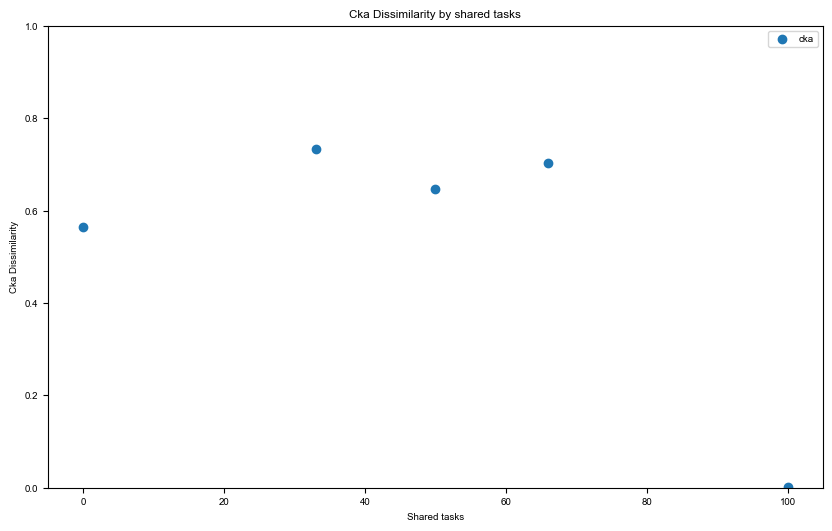

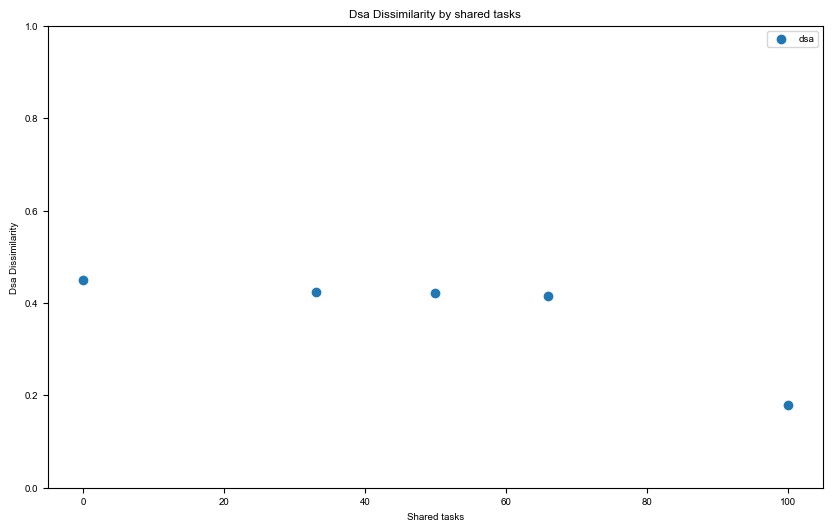

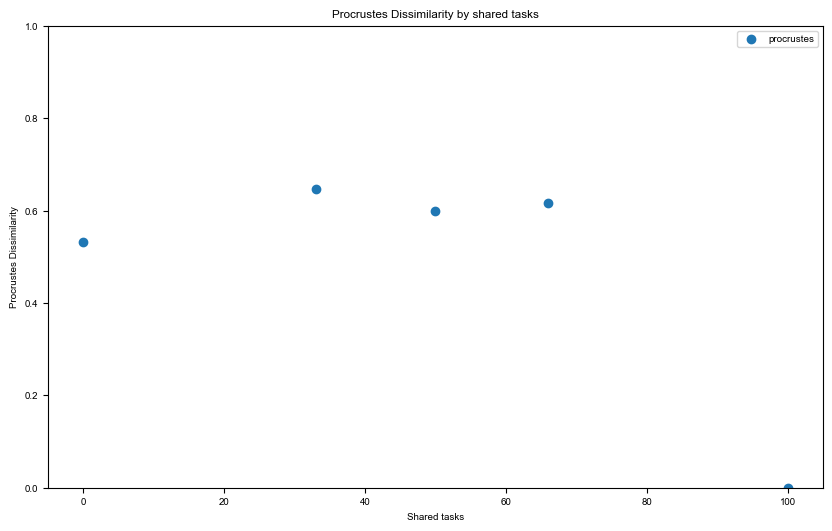

In [92]:
# plot the dissimilarities per shared task by taking median of the dissimilarities for each shared task. shared task as x-axis and dissimilarity as y-axis and do a line plot without errors
for measure in ["cka", "dsa", "procrustes"]:
    dissimilarities_per_shared_task[measure] = {
        k: np.median(v) for k, v in dissimilarities_per_shared_task[measure].items()
    }
    percent_shared_tasks_sorted = sorted(
        list(dissimilarities_per_shared_task[measure].keys())
    )
    dissimilarities = [dissimilarities_per_shared_task[measure][percent] for percent in percent_shared_tasks_sorted]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        percent_shared_tasks_sorted,
        dissimilarities,
        label=measure,
    )
    plt.xlabel("Shared tasks")
    plt.ylim(0, 1)
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity by shared tasks")
    plt.legend()
    plt.show()    

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [93]:
path = f"../data/dissimilarities_over_learning/mamba/{taskset}/pretrain_frozen_master"
measures = ["cka", "dsa", "procrustes", "accuracy_1", "accuracy_2"]
sampling = [0, 25, 50, 75, 100]
dissimilarities = {measure: [] for measure in measures}

for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            with np.load(file_path) as data:
                dissimilarities[measure].append(data["arr_0"])
dissimilarities_interpolated = {
    measure: {group: [] for group in range(len(sampling))}
    for measure in measures
}
for measure in measures:
    for dissimilarity in dissimilarities[measure]:
        print(measure)
        print(f"dissimilarity here : {dissimilarity}")
        if dissimilarity.shape[0] > 4:
            dissimilarities_interpolated[measure][0].append(dissimilarity[0])
            for i in range(len(sampling) - 1):
                index_start = int(sampling[i] / 100 * (dissimilarity.shape[0]))
                index_end = int(
                    sampling[i + 1] / 100 * (dissimilarity.shape[0])
                )
                dissimilarities_interpolated[measure][i + 1].append(
                    np.nanmedian(dissimilarity[index_start:index_end])
                )
for measure in measures:
    for group in range(len(sampling)):
        dissimilarities_interpolated[measure][group] = np.nanmean(
            dissimilarities_interpolated[measure][group]
        )
dissimilarities_groups[group_training] = dissimilarities_interpolated

cka
dissimilarity here : []
cka
dissimilarity here : []
cka
dissimilarity here : []
cka
dissimilarity here : [0.83270014]
cka
dissimilarity here : [0.7670989]
cka
dissimilarity here : []
cka
dissimilarity here : []
cka
dissimilarity here : [0.83280397 0.86352459 0.90762669]
cka
dissimilarity here : [0.2923324]
cka
dissimilarity here : [0.9389317 0.9509211]
cka
dissimilarity here : [0.6499749]
cka
dissimilarity here : []
cka
dissimilarity here : [0.44601545 0.46799901]
cka
dissimilarity here : []
cka
dissimilarity here : [0.63015595]
cka
dissimilarity here : []
cka
dissimilarity here : [0.64131269 0.71764304 0.76625249 0.83478455]
cka
dissimilarity here : [0.40667571 0.3874522  0.46945575 0.54833846]
cka
dissimilarity here : []
cka
dissimilarity here : []
cka
dissimilarity here : []
cka
dissimilarity here : [0.59099019]
dsa
dissimilarity here : []
dsa
dissimilarity here : []
dsa
dissimilarity here : []
dsa
dissimilarity here : [0.4434672]
dsa
dissimilarity here : [0.41581649]
dsa
dissim

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5646/74218426.py:34: RuntimeWarning: Mean of empty slice
  dissimilarities_interpolated[measure][group] = np.nanmean(


In [94]:
dissimilarities_groups["pretrain_frozen_master"]

{'cka': {0: 0.6269307893078192, 1: 0.636448597254632, 2: 0.7316637527729508},
 'dsa': {0: 0.45798786481221515, 1: 0.491259237130483, 2: 0.510378455122312},
 'procrustes': {0: 0.5451032521058251,
  1: 0.5516717278927356,
  2: 0.6390303304762288},
 'accuracy_1': {0: 0.7560202678044637,
  1: 0.8374325931072235,
  2: 0.9606285591920217},
 'accuracy_2': {0: 0.548649807771047,
  1: 0.548344353834788,
  2: 0.8127243518829346}}

In [95]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset)

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_mamba.py:281: RuntimeWarning: Mean of empty slice
  for measure in measures:


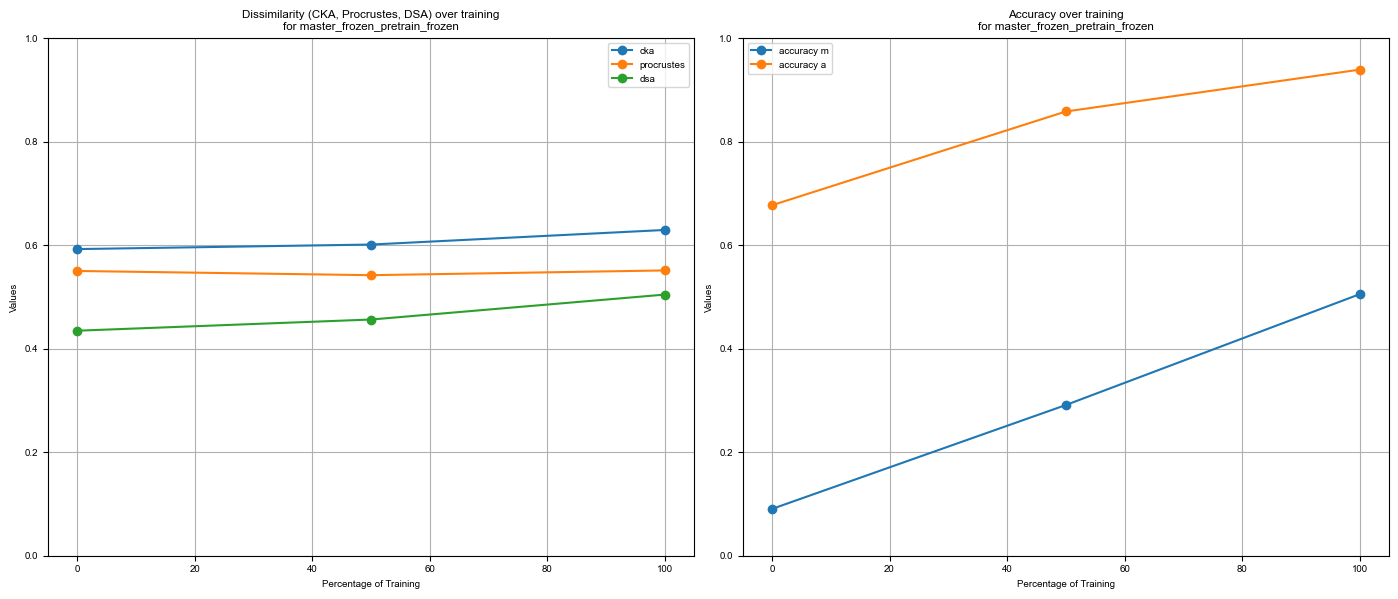

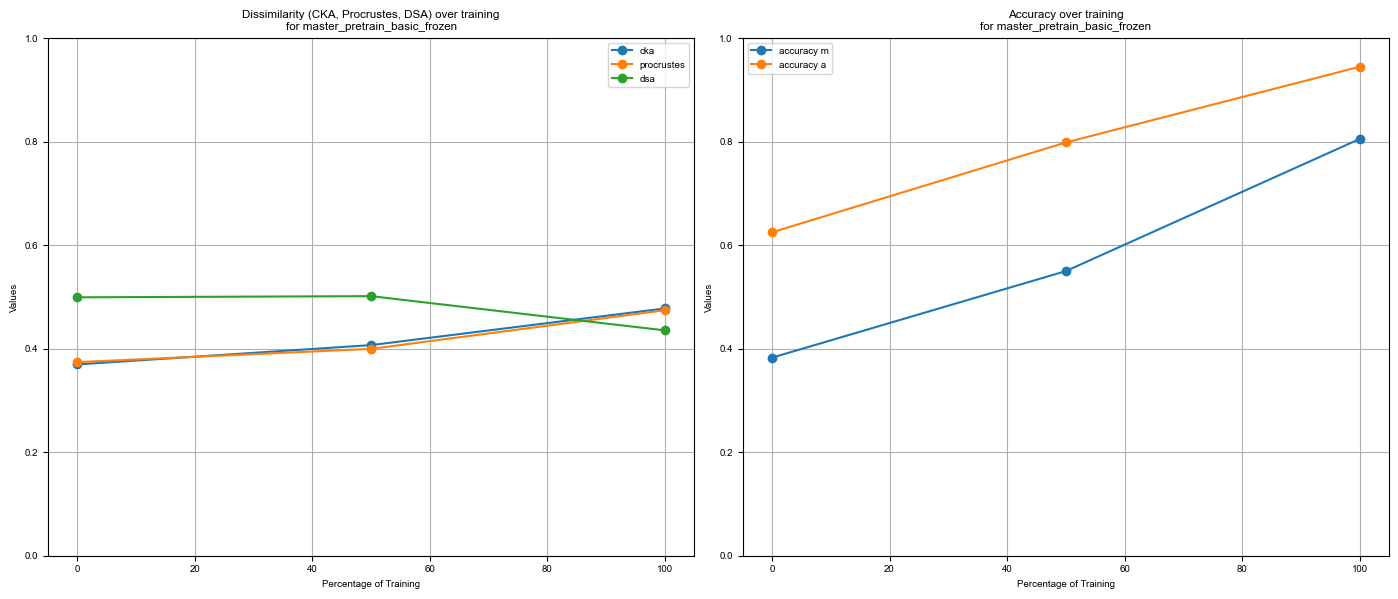

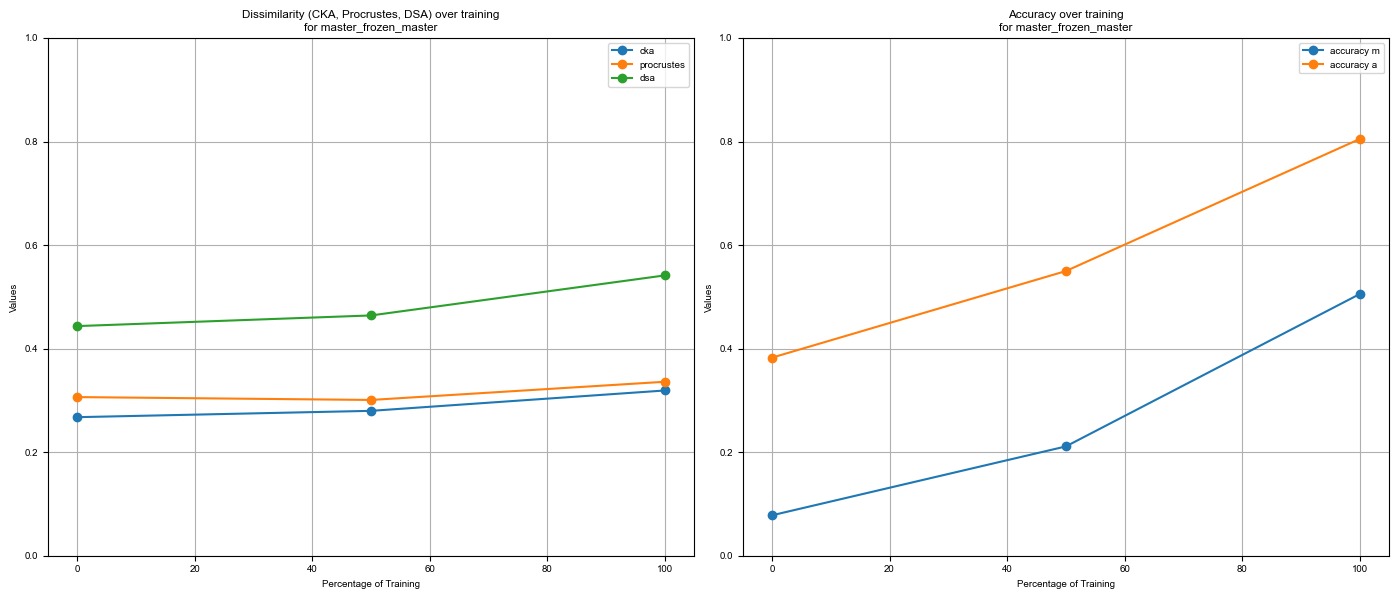

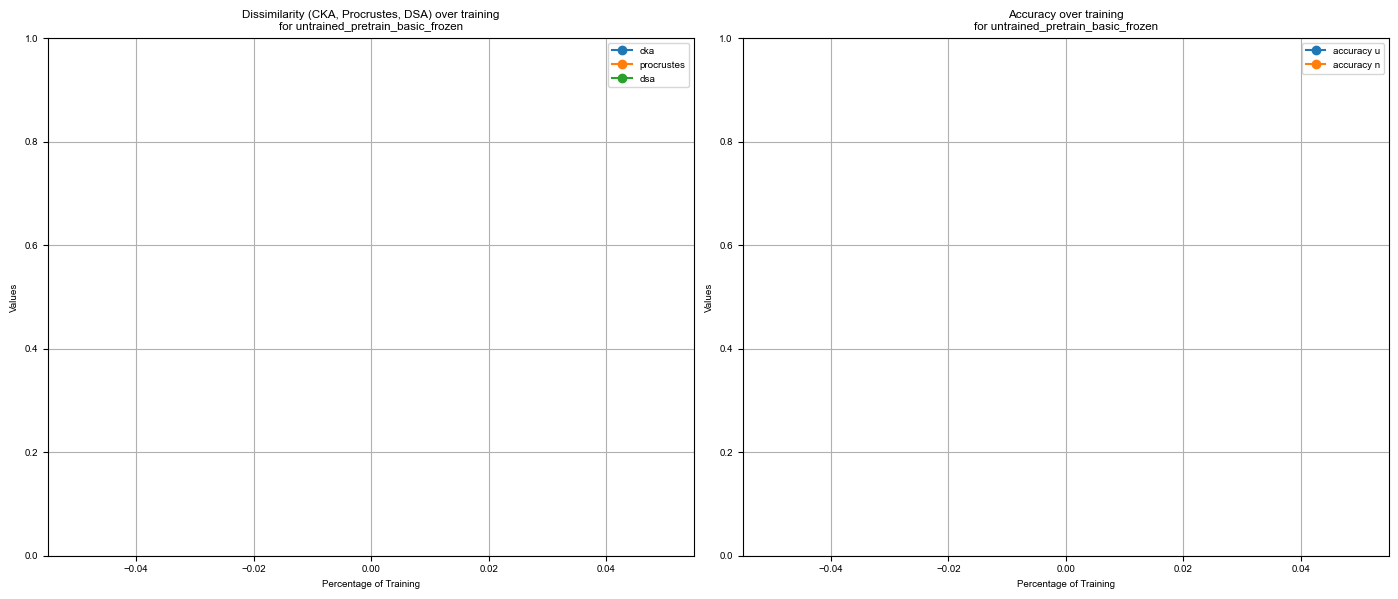

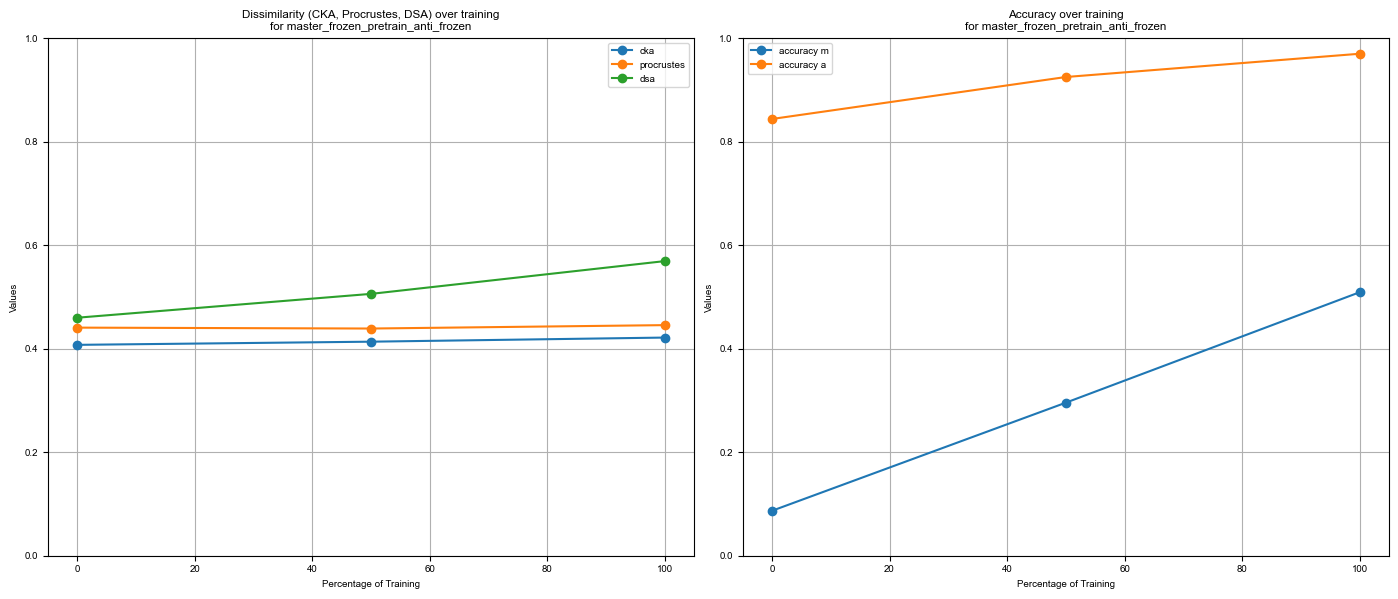

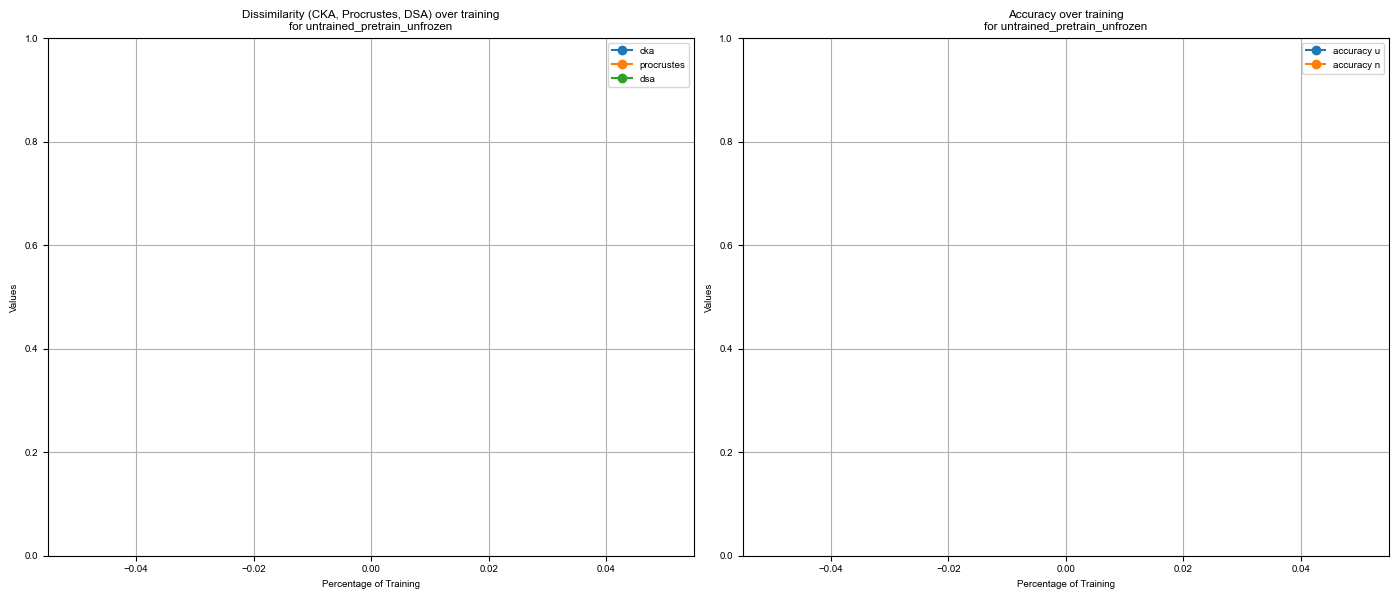

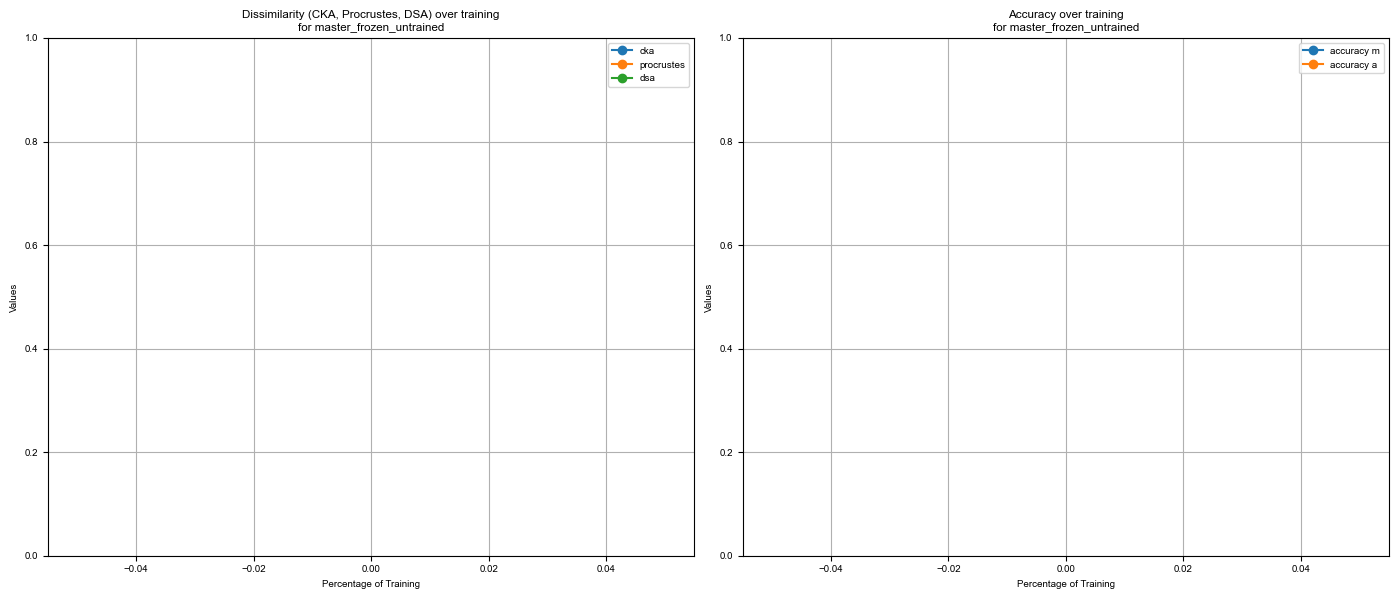

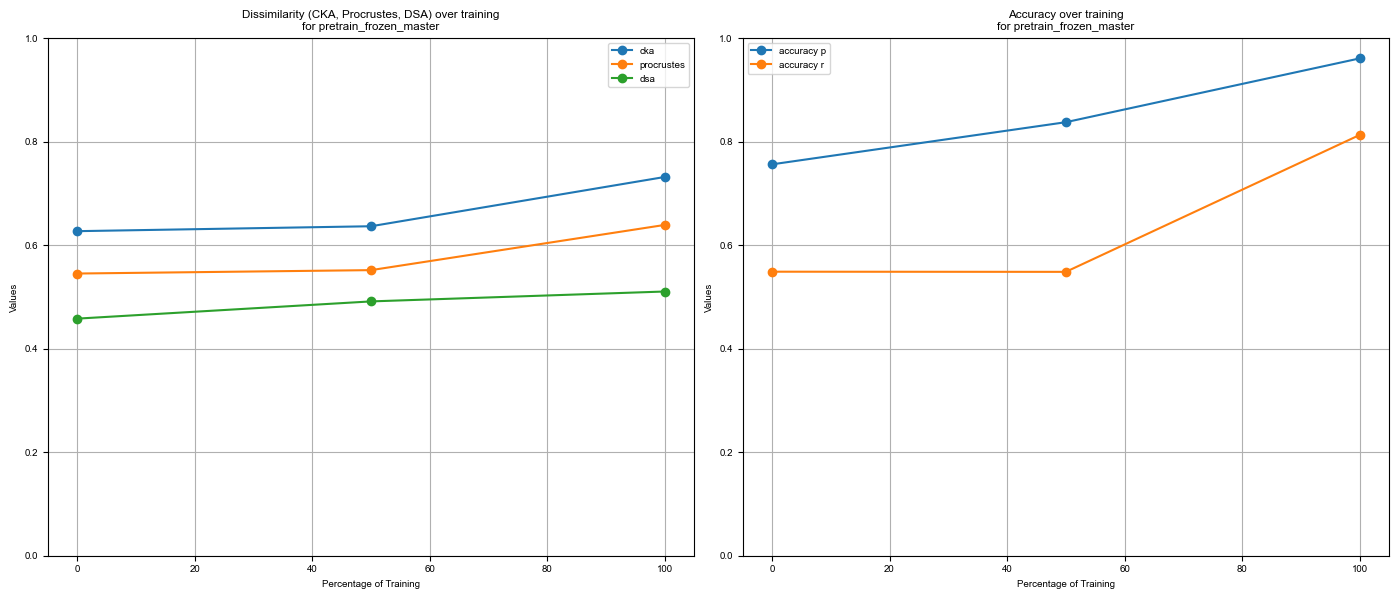

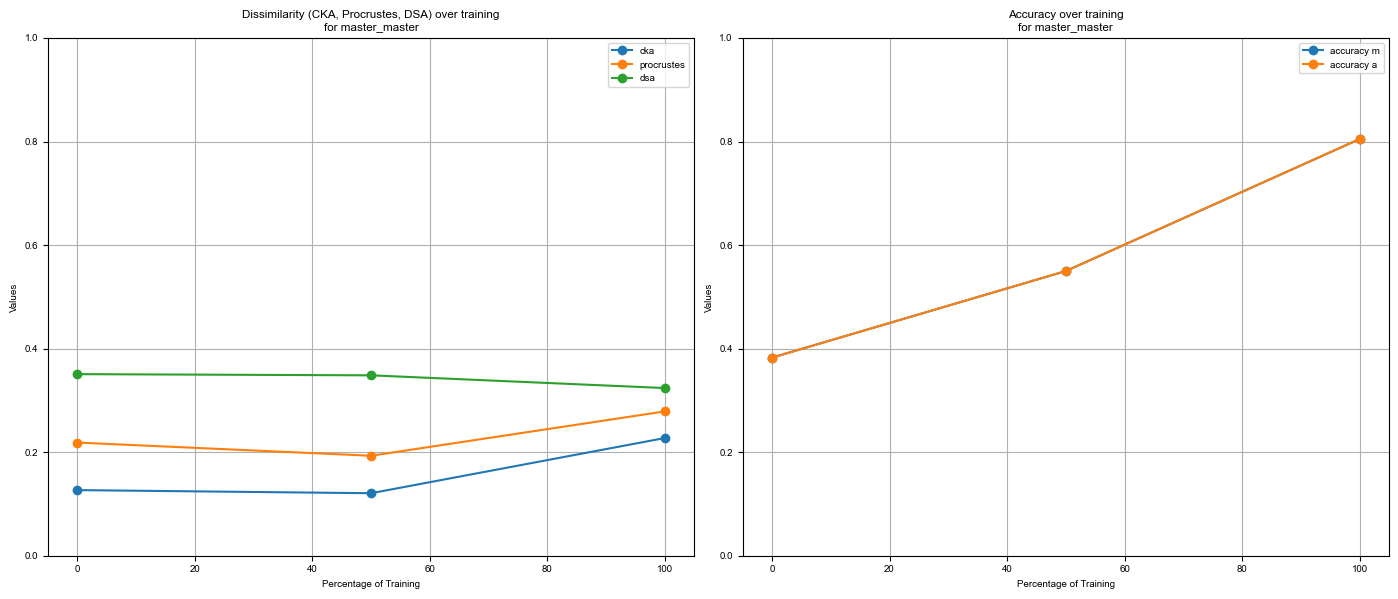

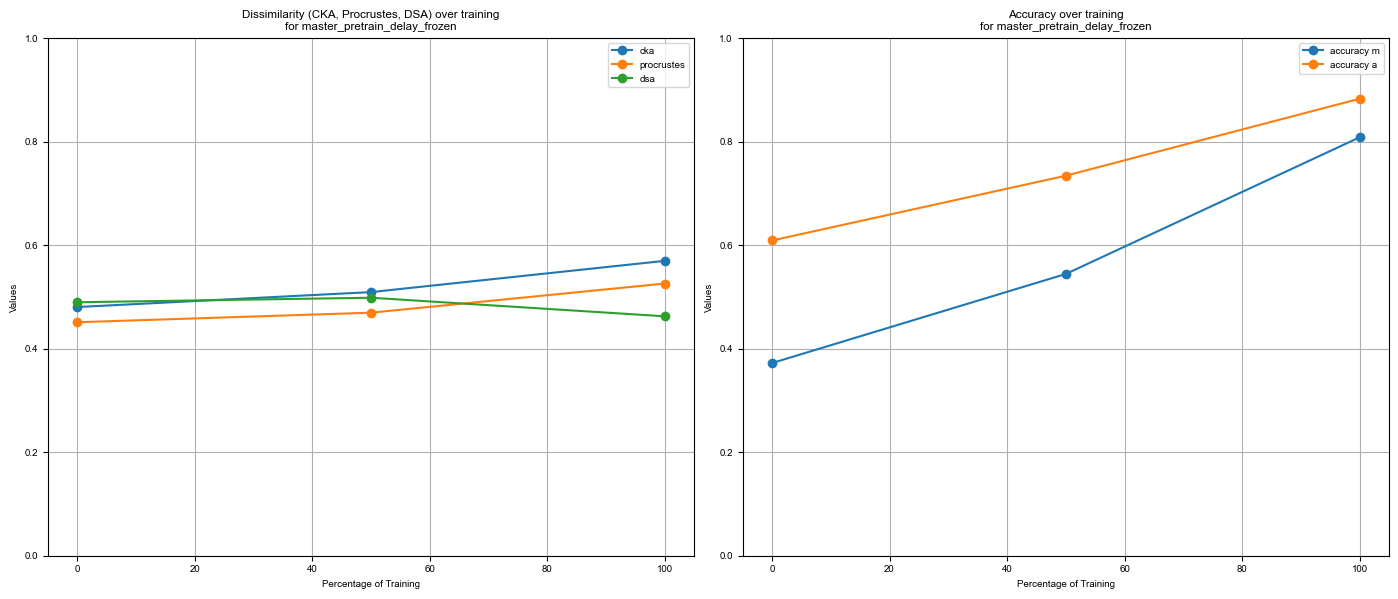

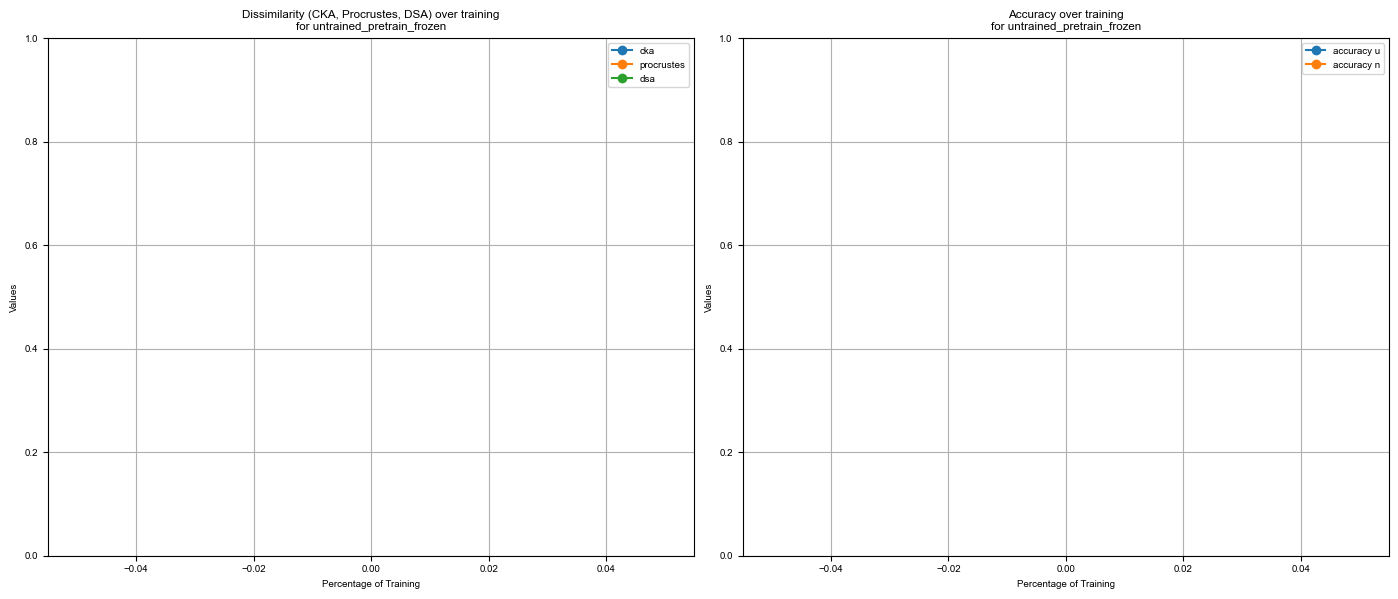

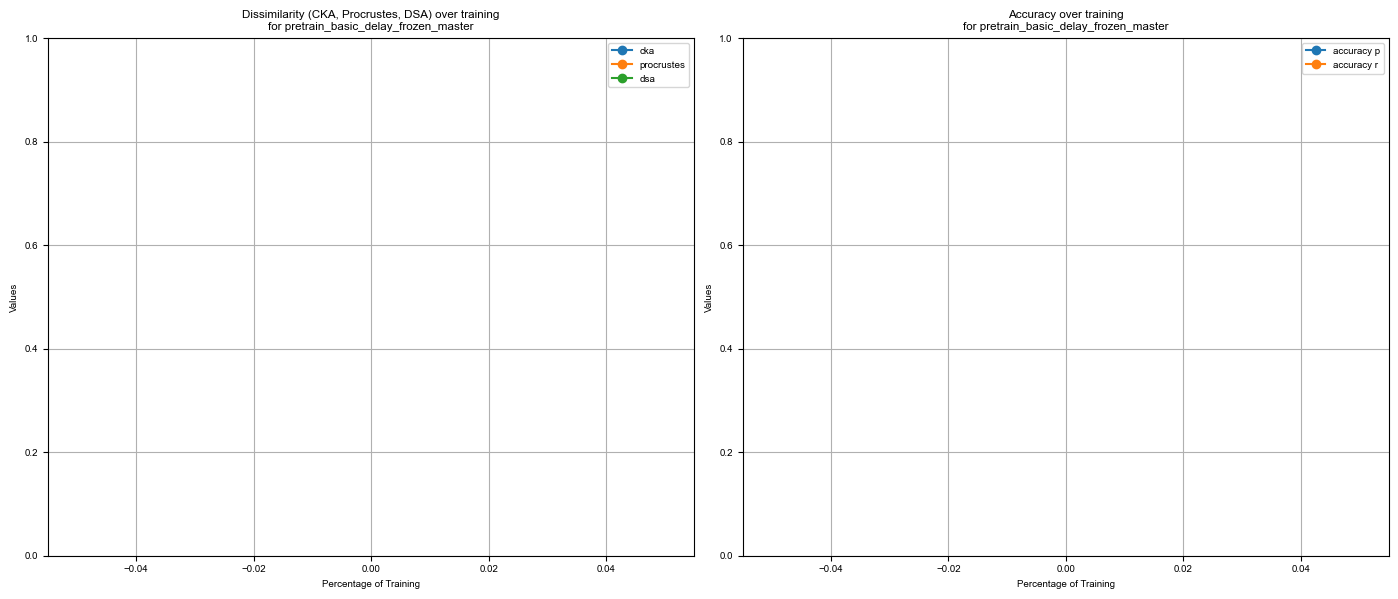

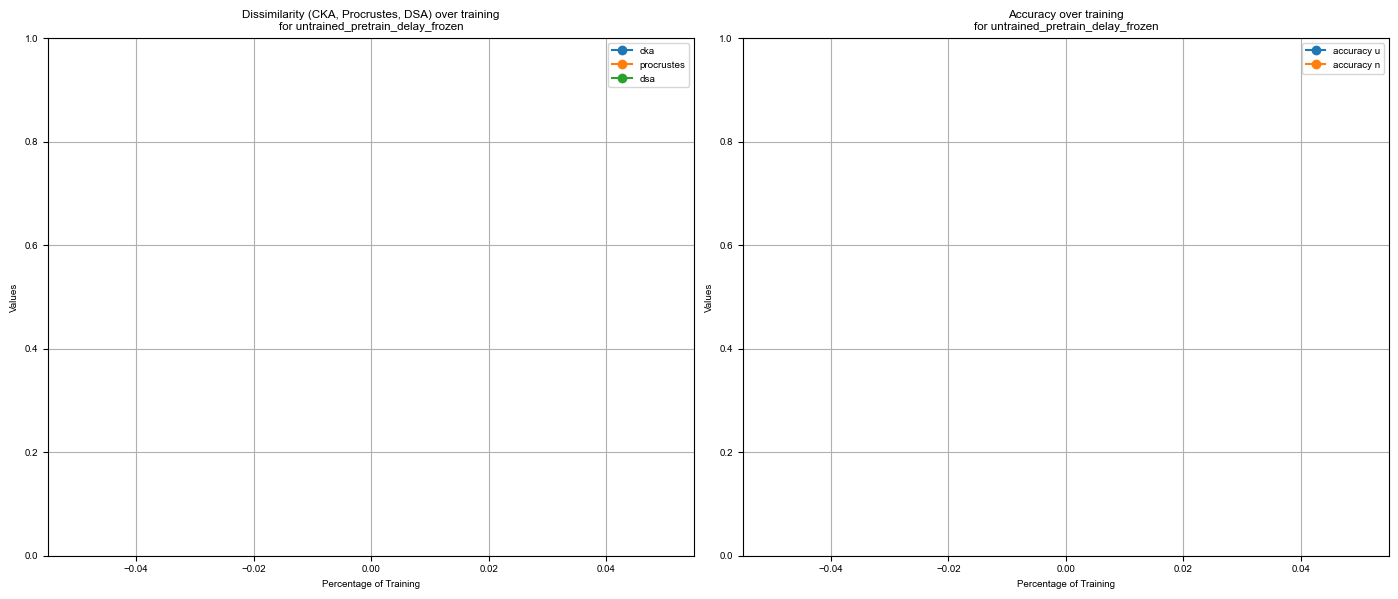

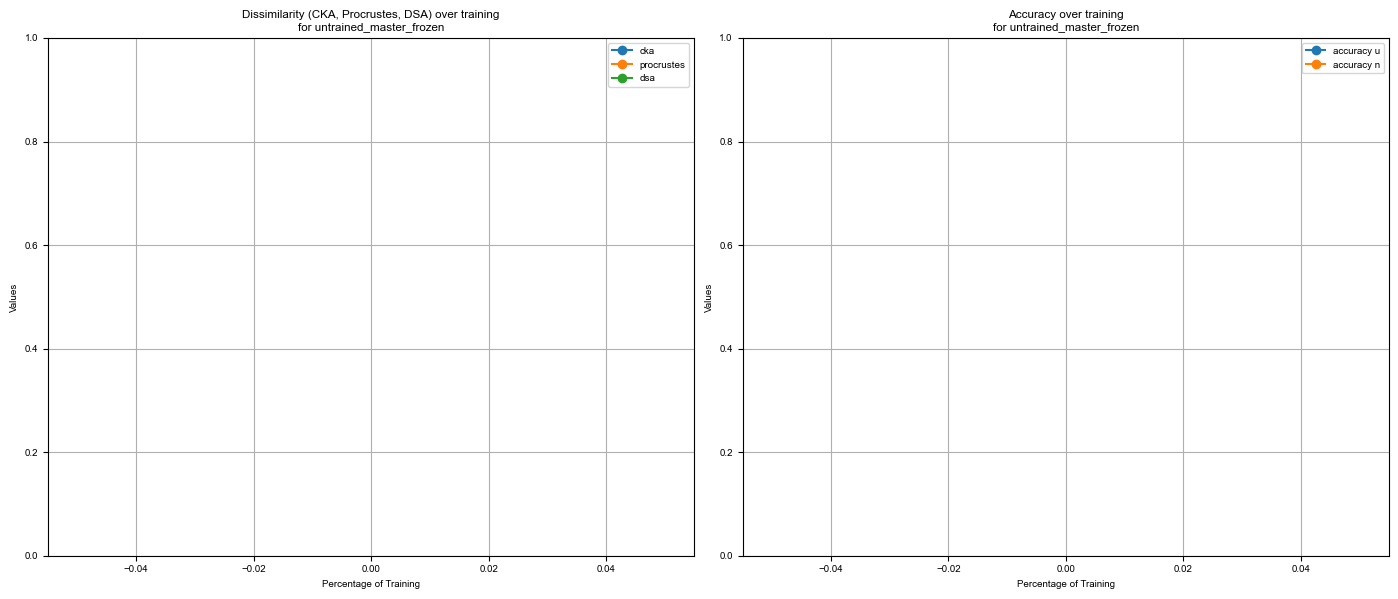

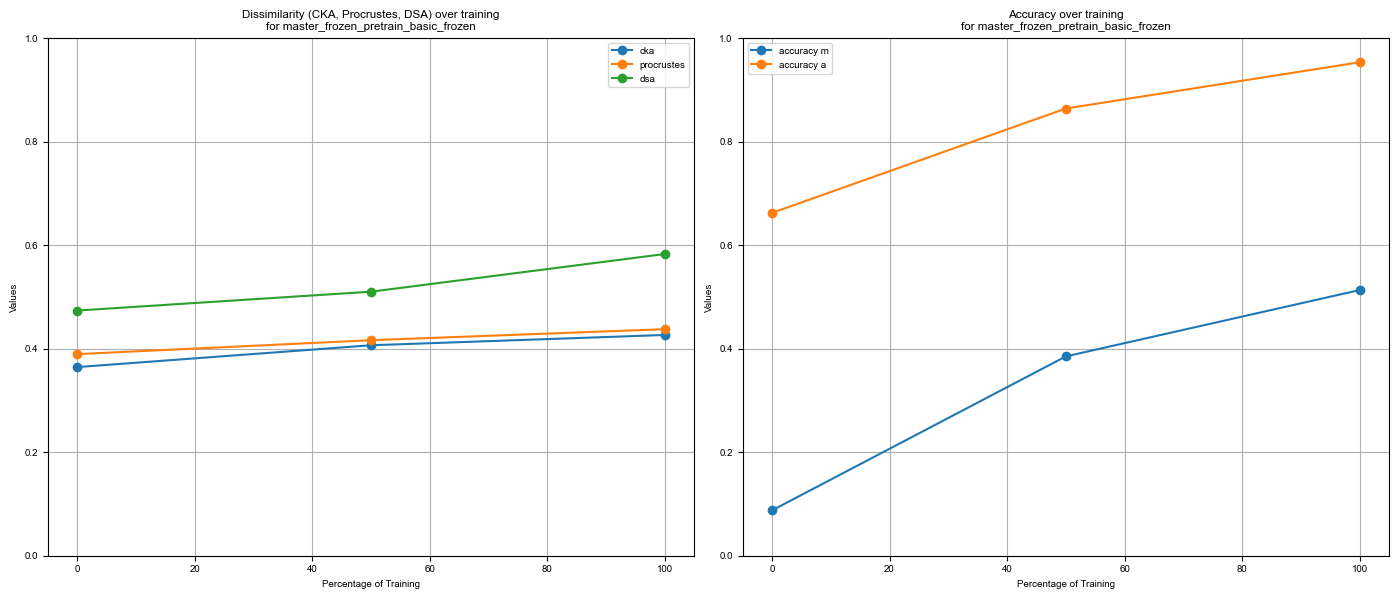

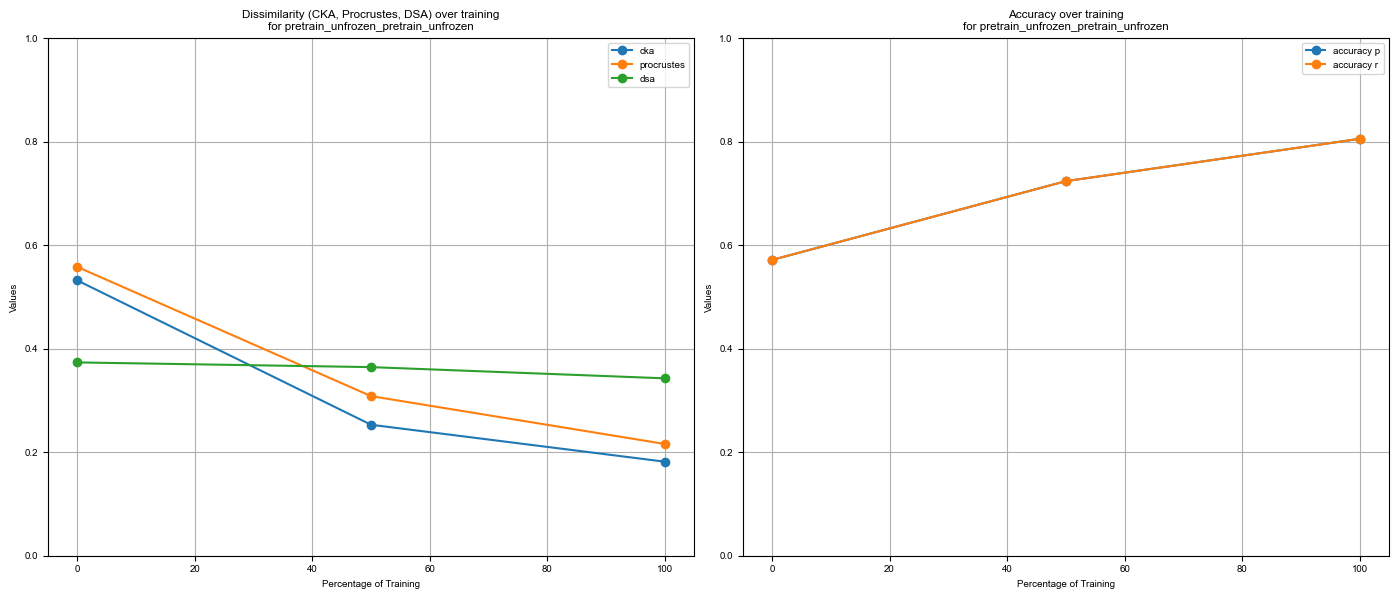

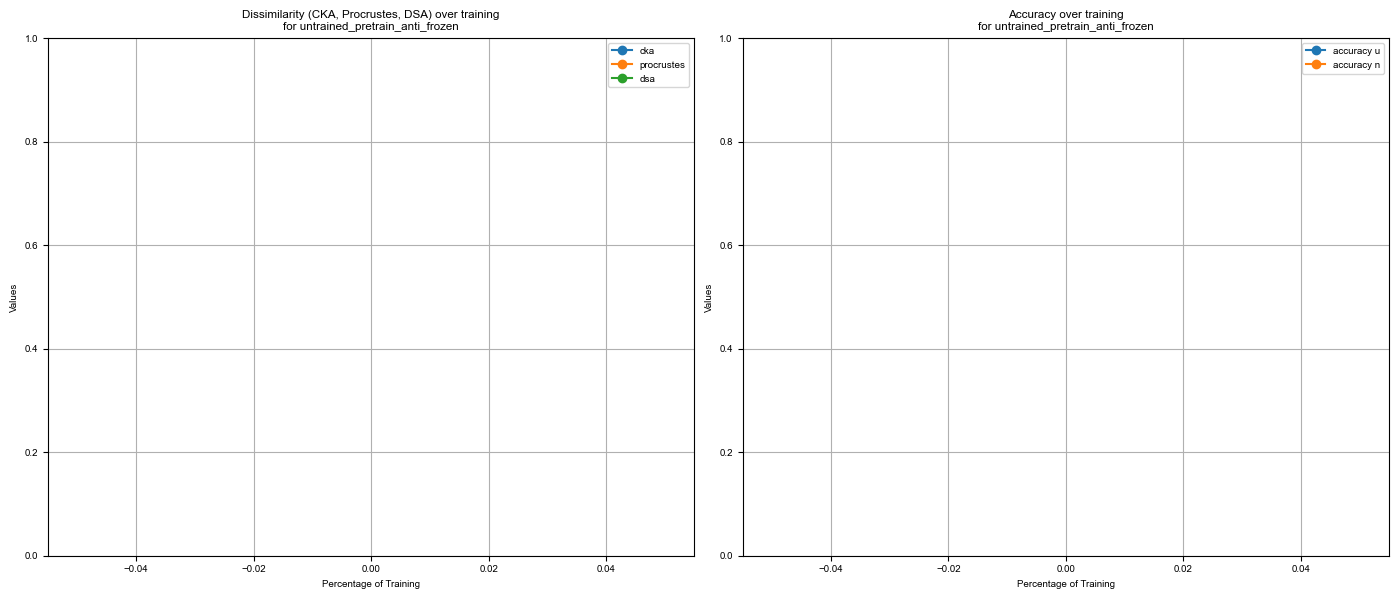

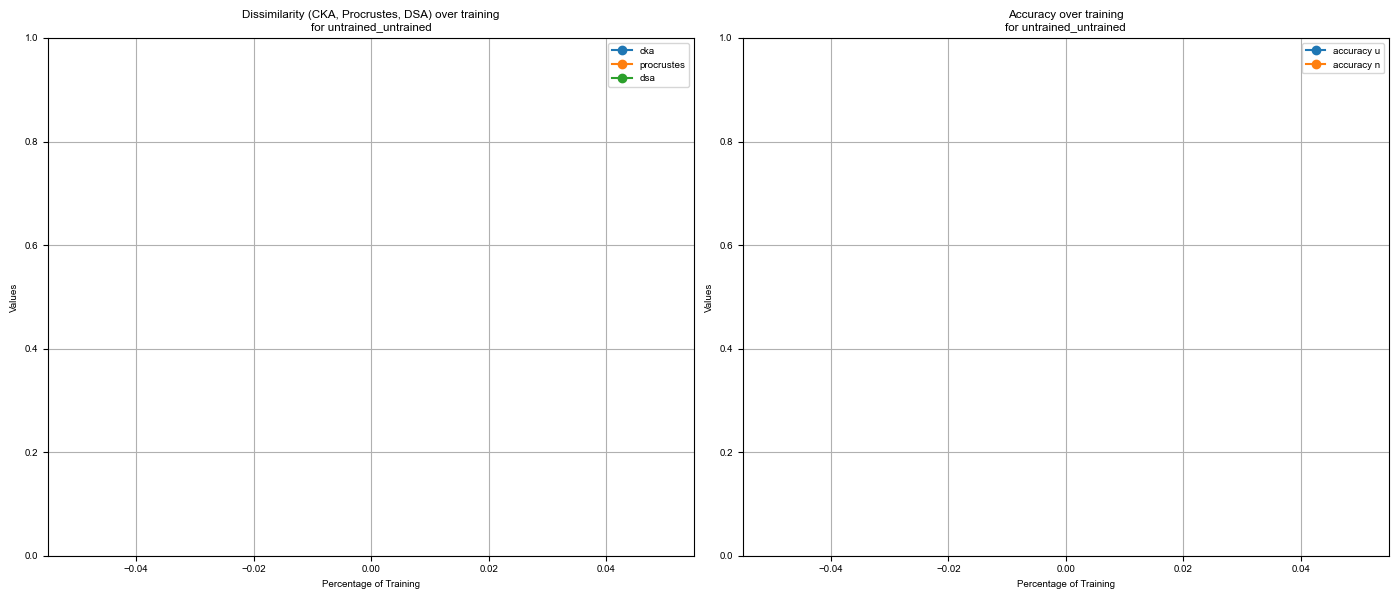

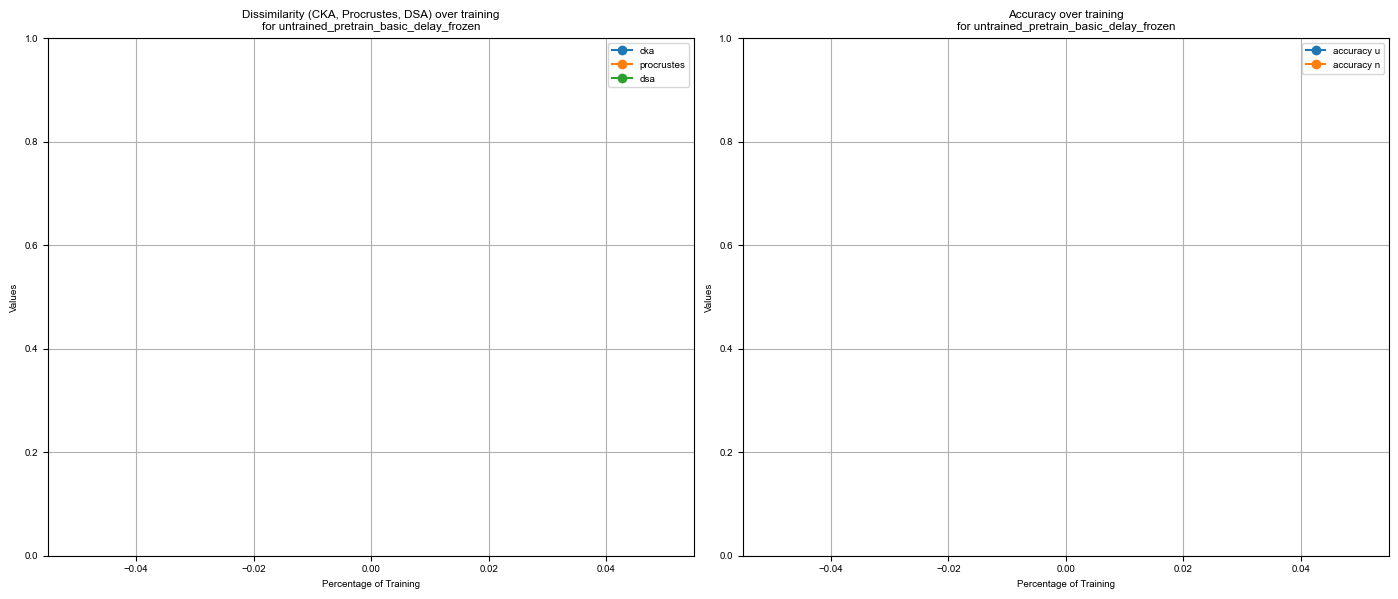

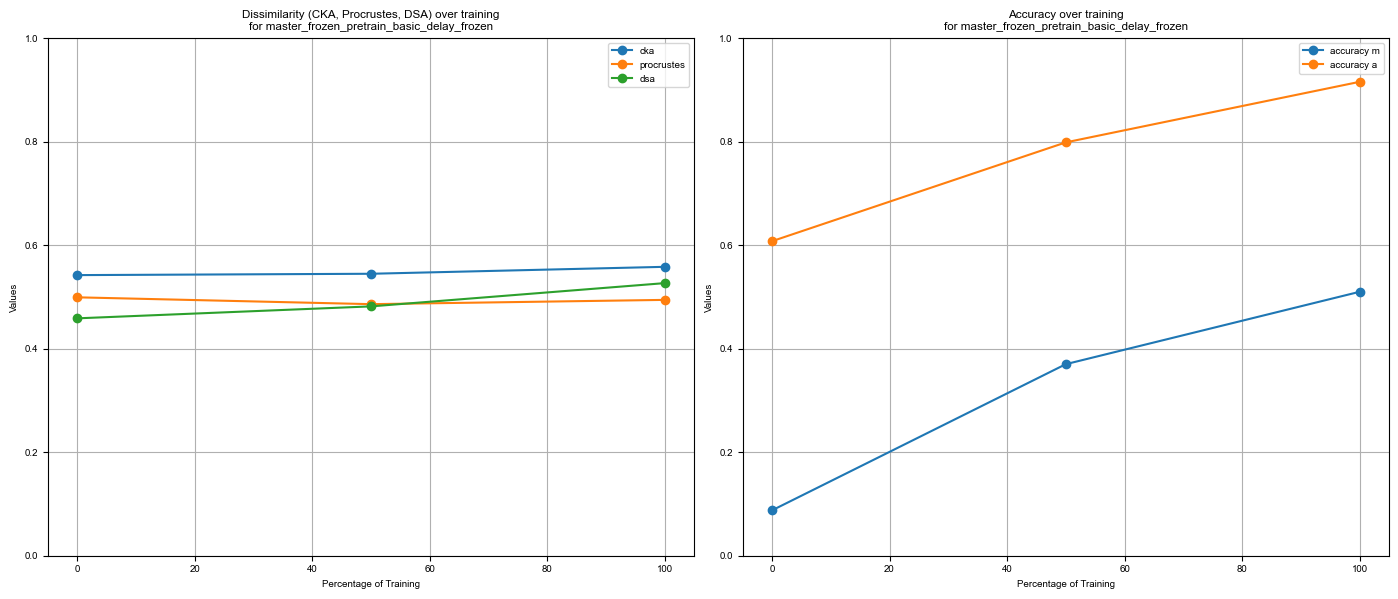

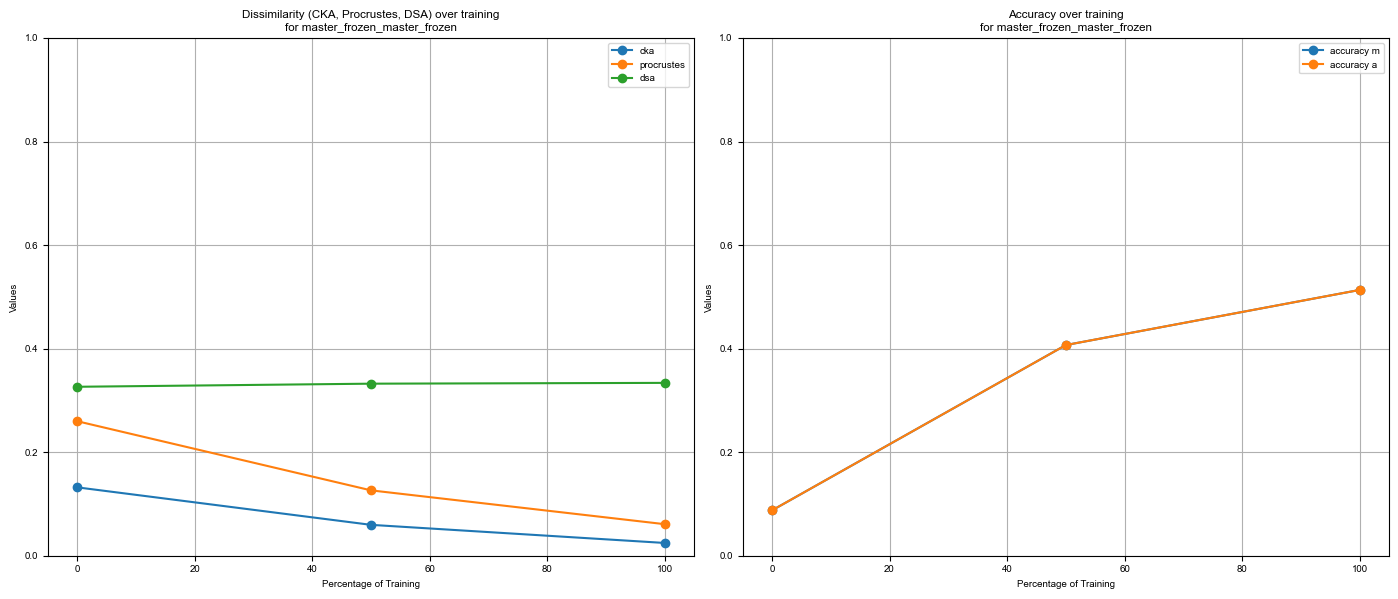

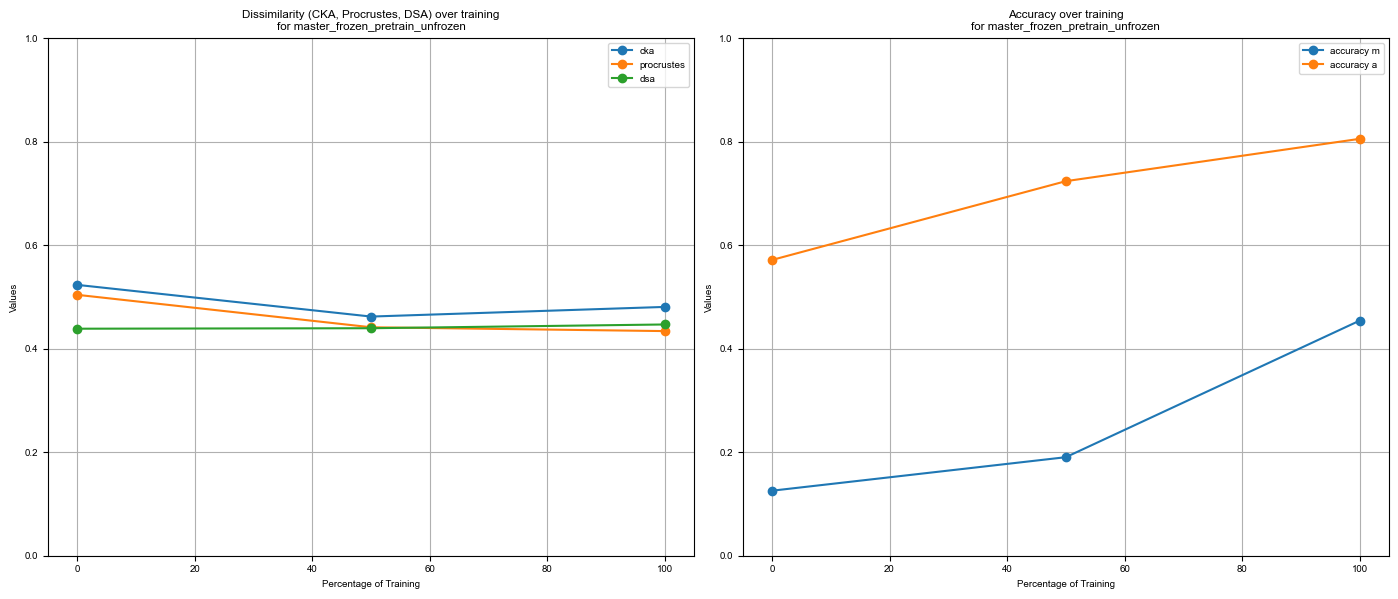

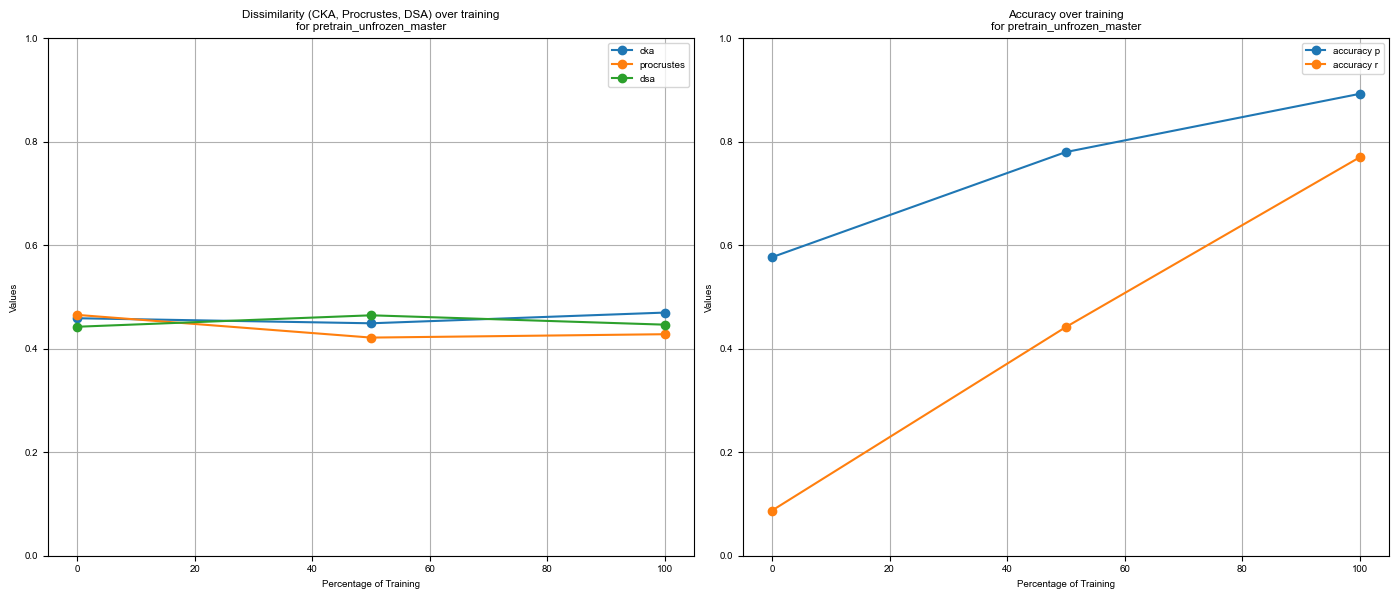

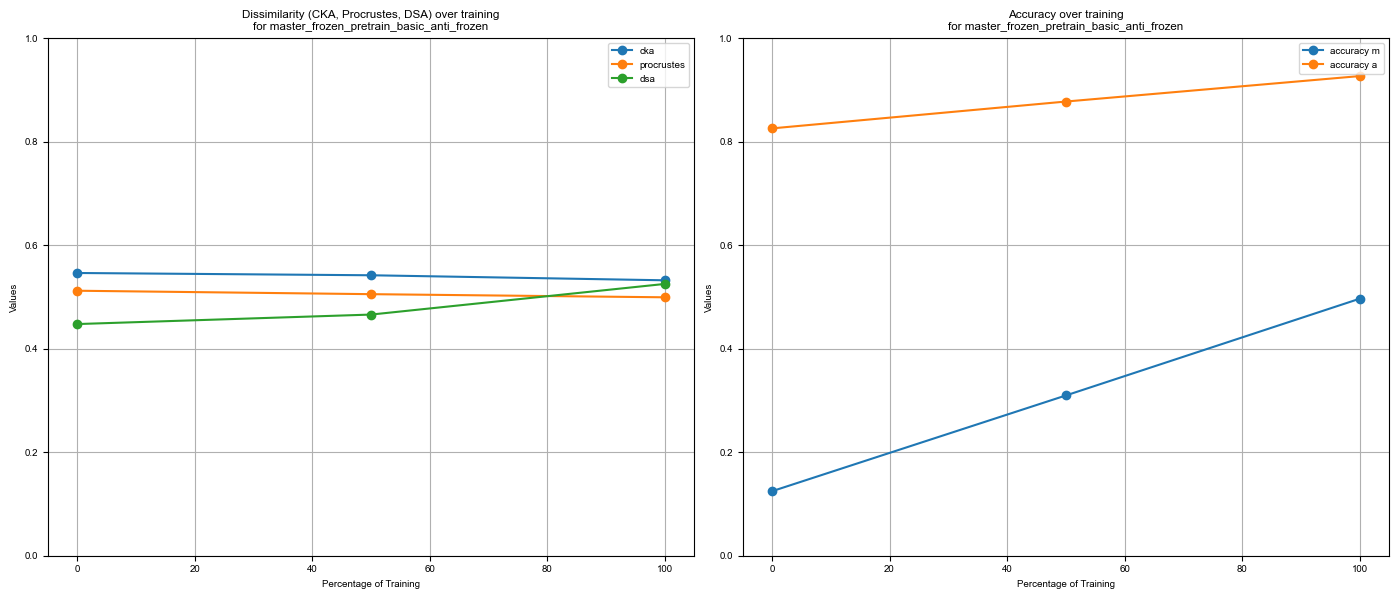

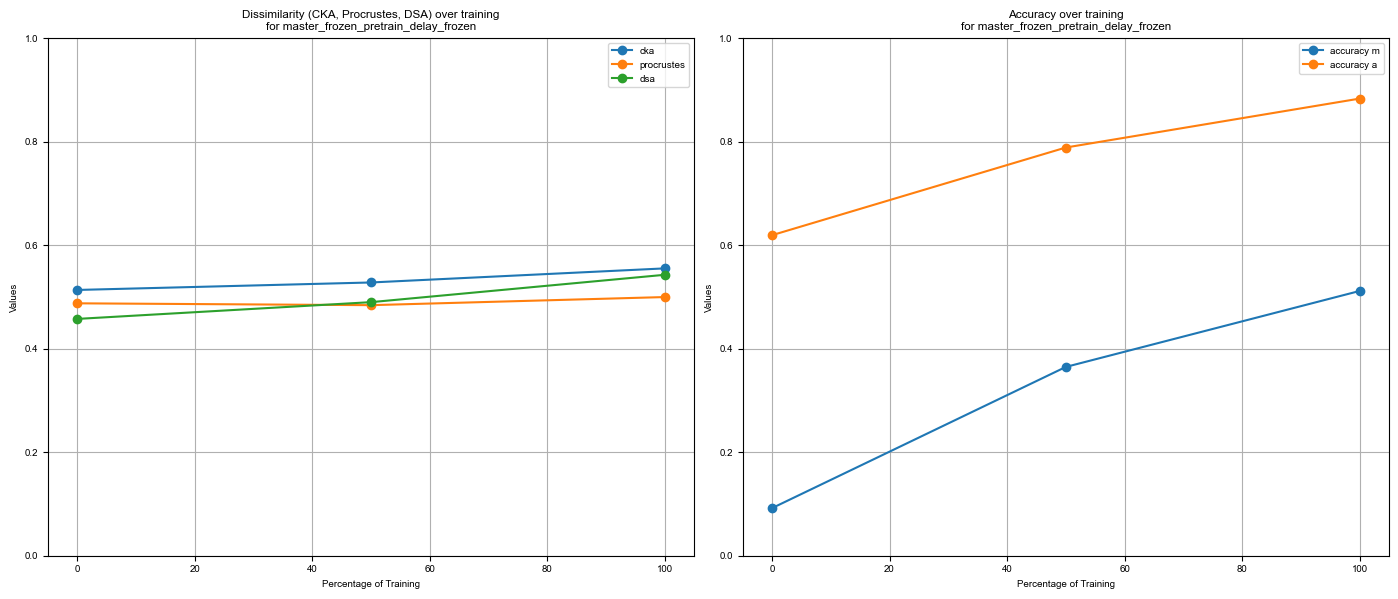

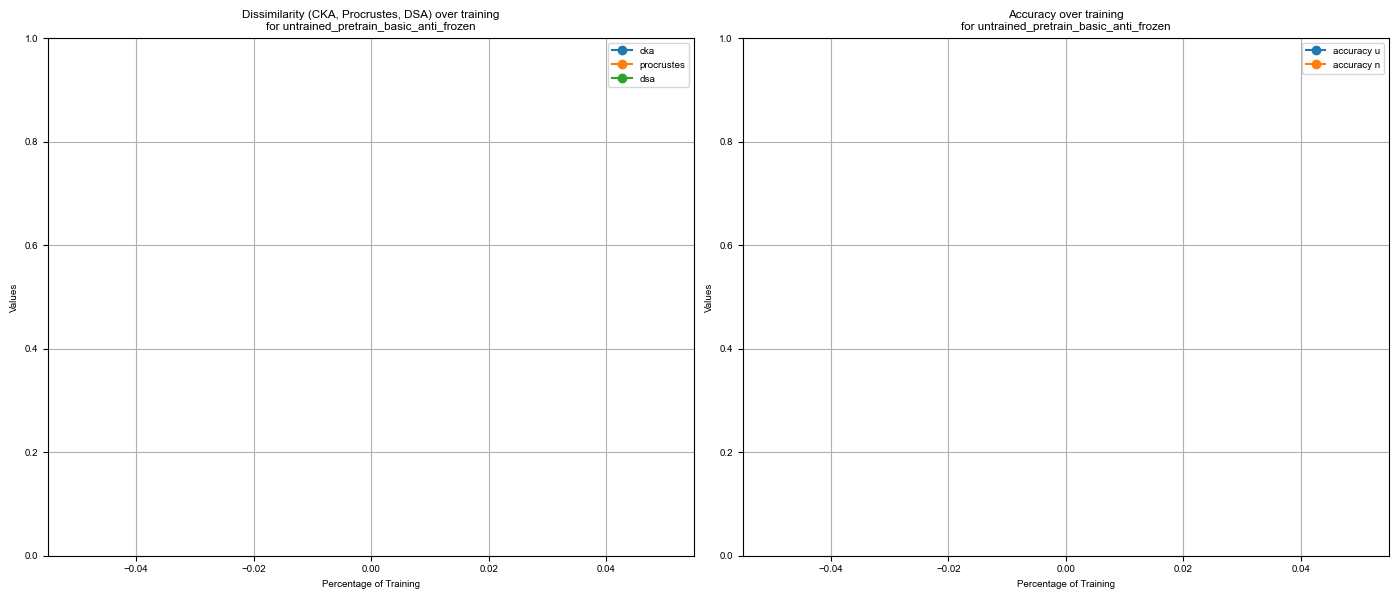

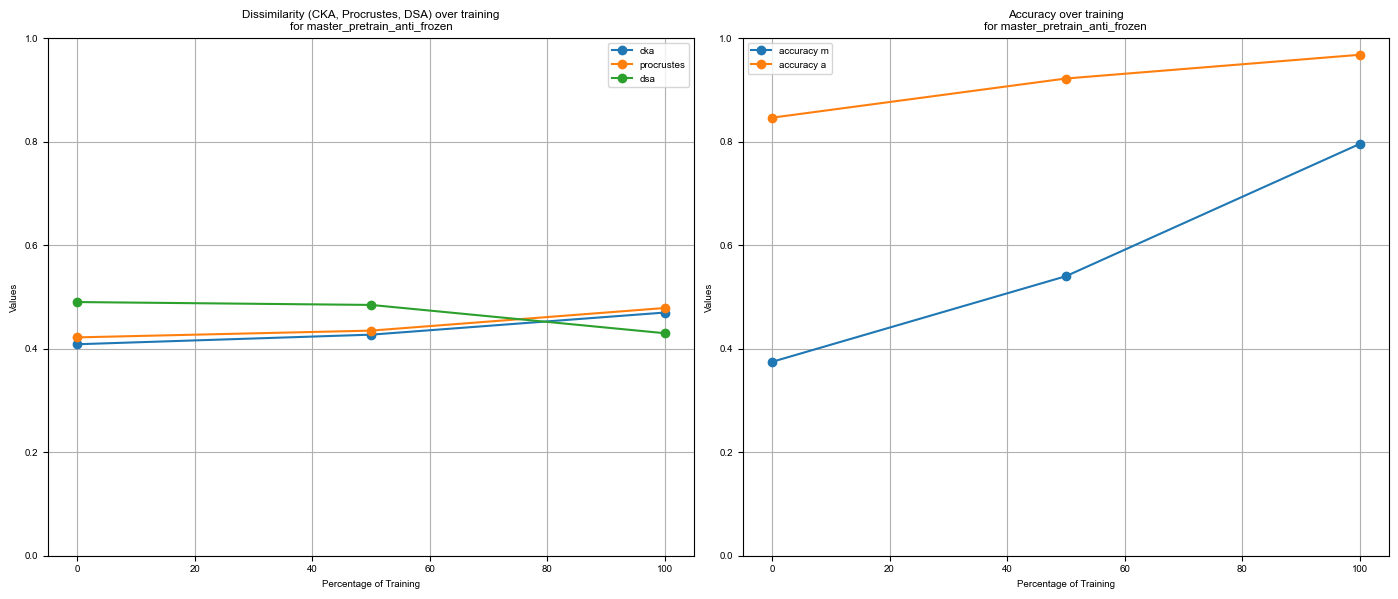

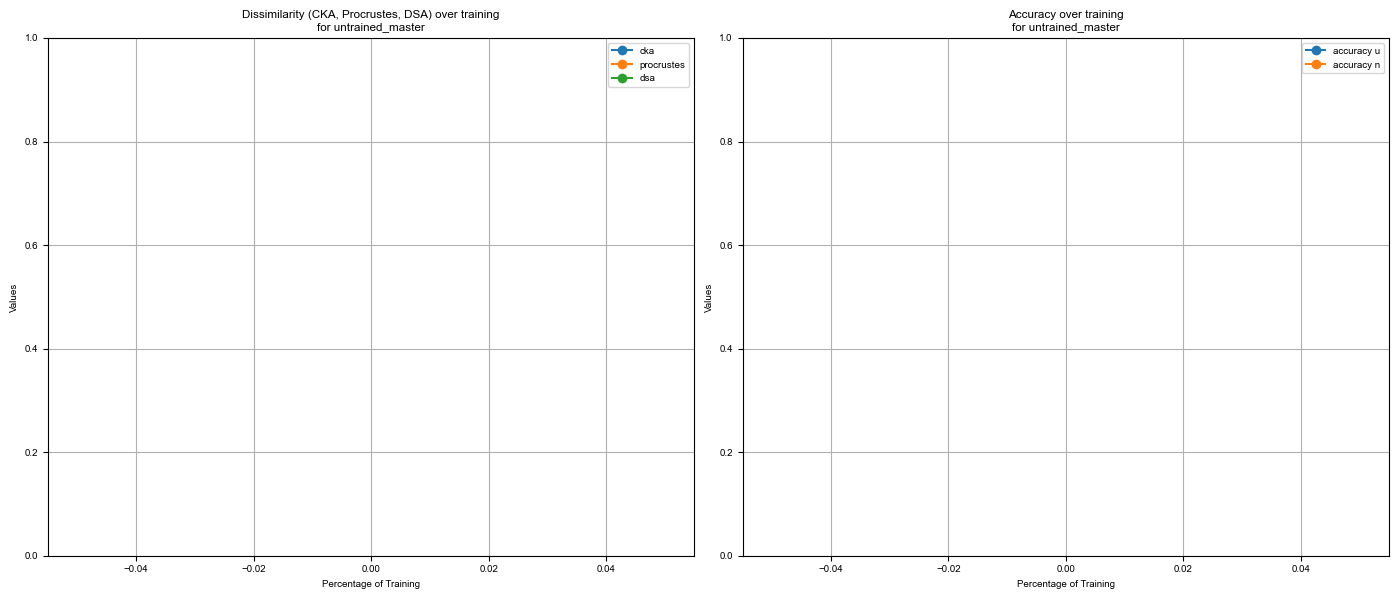

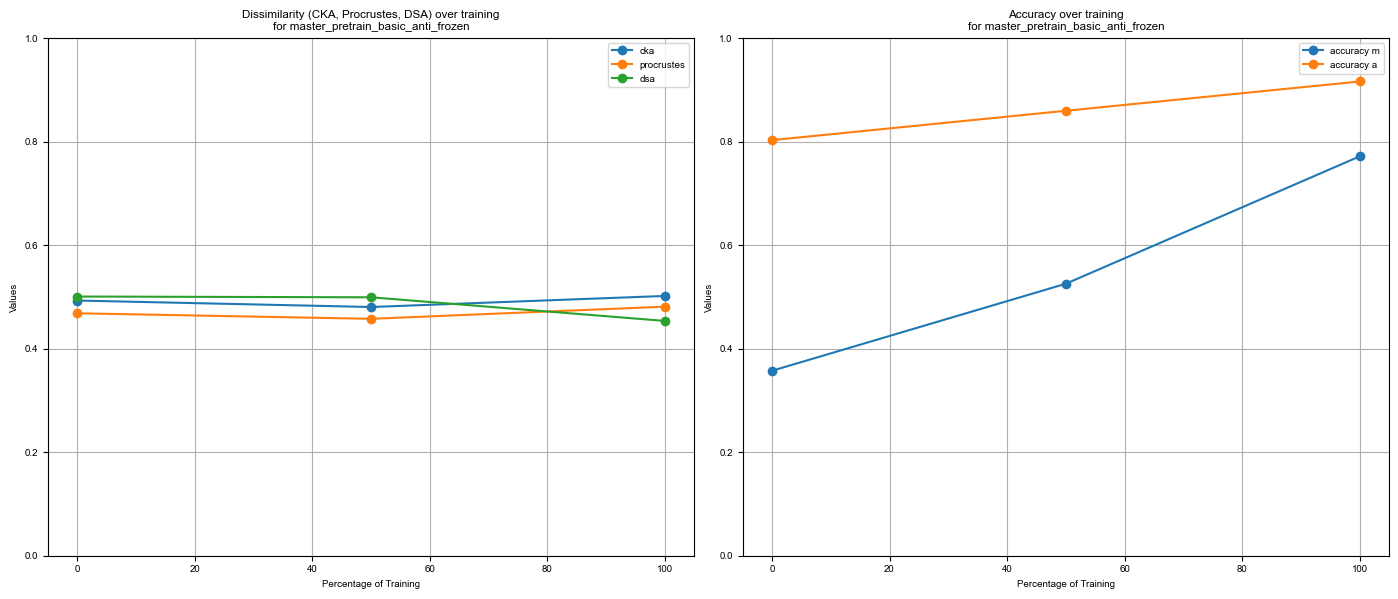

In [96]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    dissimilarities_interpolated = dissimilarities_groups[group_training]

    # X-axis values
    x_values = [0, 50, 100]

    # Measures for the two plots
    measures_plot1 = ["cka", "procrustes", "dsa"]
    measures_plot2 = ["accuracy_1", "accuracy_2"]

    # Create the figure and the two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot for the first set of measures
    for key in measures_plot1:
        values = dissimilarities_interpolated[key]
        axs[0].plot(x_values, list(values.values()), marker="o", label=key)

    axs[0].set_xlabel("Percentage of Training")
    axs[0].set_ylabel("Values")
    axs[0].set_title(
        "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
            group_training
        )
    )
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # Plot for the second set of measures
    for i, key in enumerate(measures_plot2):
        values = dissimilarities_interpolated[key]
        # Rename legend label for accuracy
        label = f"accuracy {group_training[i]}"
        axs[1].plot(x_values, list(values.values()), marker="o", label=label)

    axs[1].set_xlabel("Percentage of Training")
    axs[1].set_ylabel("Values")
    axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
    axs[1].set_ylim(0, 1)
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout to avoid overlapping elements
    plt.tight_layout()

    # Display the plots
    plt.show()

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_mamba.py:313: RuntimeWarning: Mean of empty slice
  for i in range(len(x_values)):


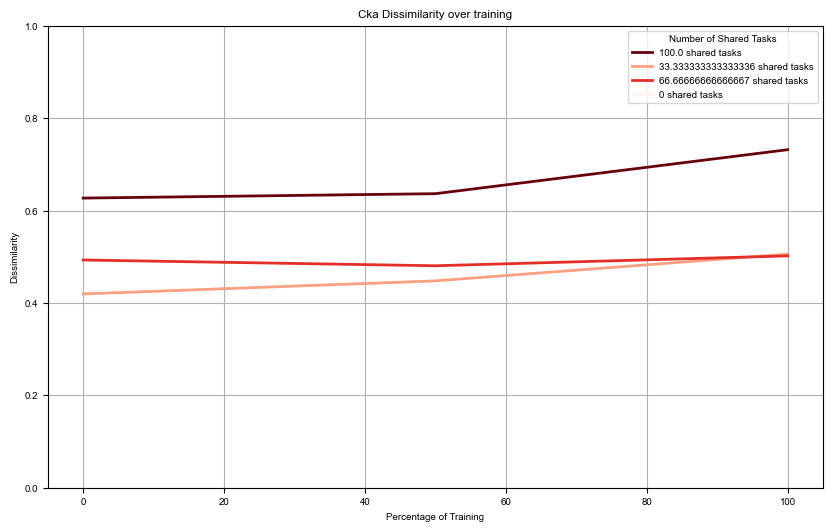

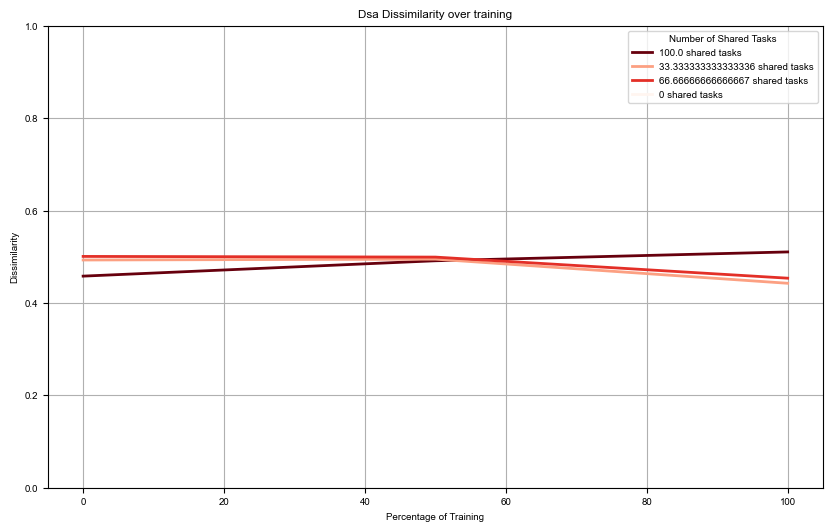

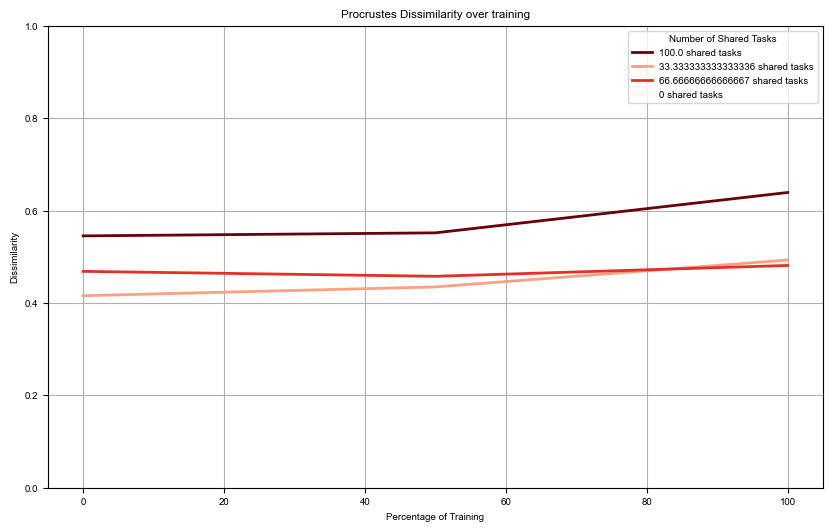

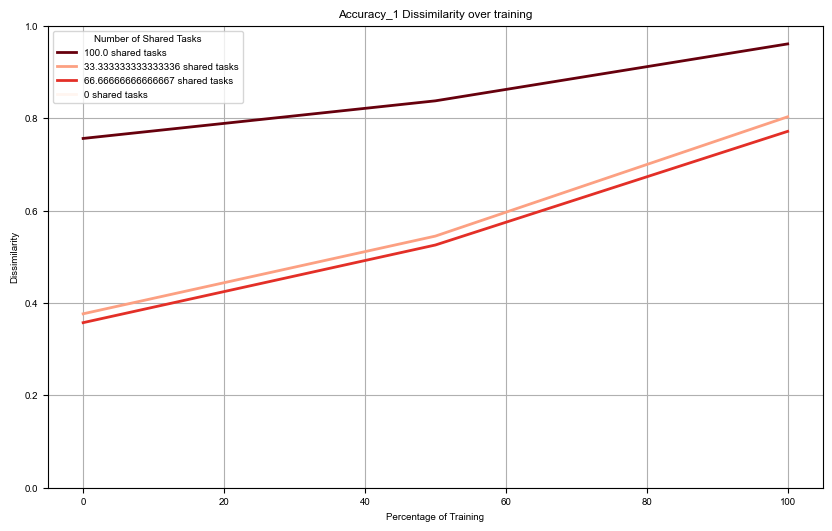

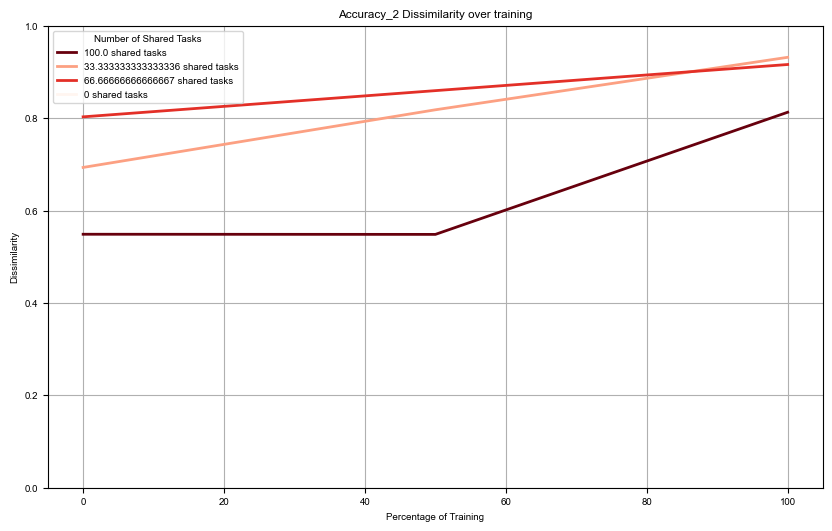

In [97]:
group_pairs_master = find_group_pairs_master(config, taskset)
diss_cc_master = get_dissimilarities_shared_task_shared_curriculum(
    group_pairs_master, dissimilarities_groups, x_values
)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Normalize the number of shared tasks to range between 0 and 1 for color mapping
all_shared_tasks = [
    shared for measure in diss_cc_master for shared in diss_cc_master[measure]
]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Create a colormap ranging from light to dark blue
cmap = cm.Reds

# Plot each measure
for measure in diss_cc_master:
    plt.figure(figsize=(10, 6))  # Create a new figure for each measure
    for shared in diss_cc_master[measure]:
        x_new, y_new = diss_cc_master[measure][shared]

        # Normalize shared task count to get a color
        norm_shared = (shared - min_shared) / (max_shared - min_shared)
        color = cmap(norm_shared)  # Get the color from the colormap

        plt.plot(x_new, y_new, label=f"{shared} shared tasks", color=color, linewidth=2)

    plt.xlabel("Percentage of Training")
    plt.ylim(0, 1)
    plt.ylabel("Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity over training")
    plt.legend(title="Number of Shared Tasks")
    plt.grid(True)
    plt.show()

In [98]:
group_pairs_master

{100.0: [('master', 'pretrain_frozen')],
 33.333333333333336: [('master', 'pretrain_basic_frozen'),
  ('master', 'pretrain_anti_frozen'),
  ('master', 'pretrain_delay_frozen')],
 66.66666666666667: [('master', 'pretrain_basic_anti_frozen'),
  ('master', 'pretrain_basic_delay_frozen')],
 0: [('master', 'untrained')]}

### Dissimilarity within group 

In [99]:
path = f"../data/dissimilarities_within_learning_averaged_curves_50_1/mamba/{taskset}/master"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if "mamba_8" in file_path:
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.nanmedian(np.stack(value, axis=0), axis=0)

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5646/1070968890.py:33: RuntimeWarning: All-NaN slice encountered
  dissimilarities[measure] = np.nanmedian(np.stack(value, axis=0), axis=0)


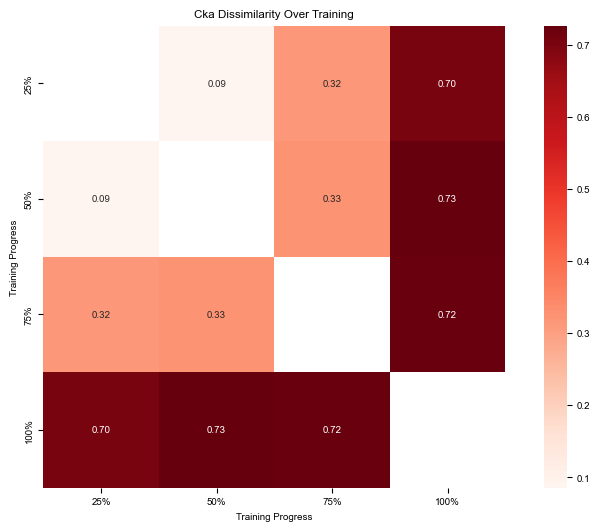

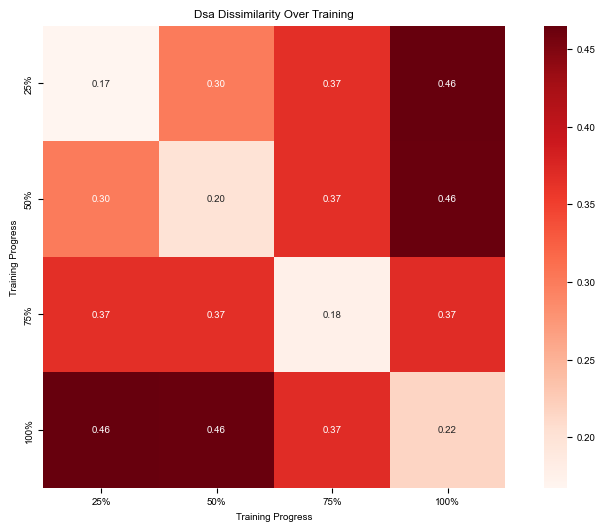

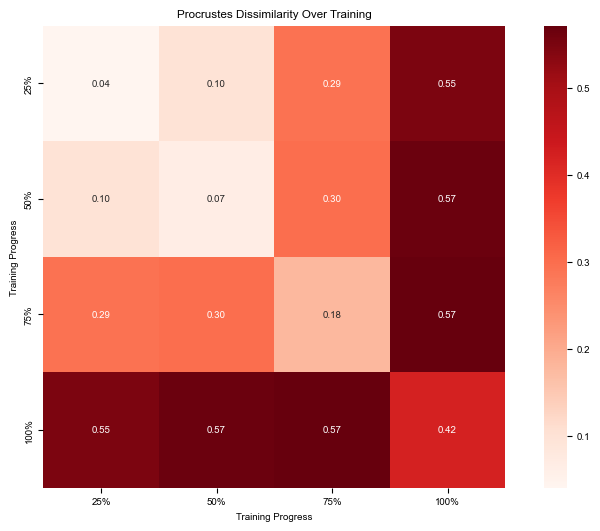

In [100]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()